In [1]:
from typing import Tuple, Optional, Union
import math
import torch as th
import torch
import torch.nn as nn
import torchaudio as ta
from torchaudio.transforms import PSD
import torch.nn.functional as F

from Modules import STFT, MVDR
from model import Unet_model
from data import my_dataset
from matplotlib import pyplot as plt
from loss import MultiResSpecLoss

In [2]:
import torch
import torch.nn as nn
import math
from torch.nn import functional as F
from model import DownSample, UpSample

class Unet_model(nn.Module):
    def __init__(
        self, input_channel=1, out_channel=32, complex_input=True, log_flag=True, subband_flag=False):
        super().__init__()
        self.complex_input = complex_input
        self.log_flag = log_flag
        self.subband_flag = subband_flag
        
        self.down_1 = DownSample(
                input_channel=40,
                out_channel=64, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(64)
            )
        
        self.down_2 = DownSample(
                input_channel=64,
                out_channel=128, 
                kernel_size=(4, 3), 
                stride=(4, 1),
                activation = nn.GELU(),
                normalization = nn.BatchNorm2d(128)
            )
        
        self.lstm = nn.LSTM(input_size=256, 
                            hidden_size=256, 
                            num_layers=1, 
                            batch_first=True)
        
        
        self.up_1 = UpSample(
            input_channel=128+128, 
            out_channel=64, 
            kernel_size=(6, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(64)
        )    
        

        self.up_2 = UpSample(
            input_channel=64+64, 
            out_channel=32, 
            kernel_size=(4, 3), 
            stride=(4, 1),
            activation = nn.GELU(),
            normalization = nn.BatchNorm2d(32)
        )   
        
        
        self.fc = nn.Sequential(
            nn.Linear(40*32, 200),
            nn.Sigmoid()
        )
    
    def cac2cws(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c,k,f//k,t)
        x = x.reshape(b,c*k,f//k,t)
        return x
    
    def cws2cac(self, x):
        k = 5
        b,c,f,t = x.shape
        x = x.reshape(b,c//k,k,f,t)
        x = x.reshape(b,c//k,f*k,t)
        return x
    
    def forward(self, x):
        B, C, F, T = x.shape
        
        if self.complex_input:
            x = torch.concat([x.real, x.imag], dim=1)
        elif self.log_flag:
            x = torch.log(x + 1e-5)
        
        if self.subband_flag:
            x = self.cac2cws(x)
        
        x1 = self.down_1(x)
        x2 = self.down_2(x1)        
        _, C_c, F_c, _ = x2.shape
        x = x2.view(B, -1, T).permute(0, 2, 1) # (B, C, F, T) -> (B, C*F, T) -> (B, T, C*F)
        
        x = self.lstm(x)[0] + x
        
        x = x.permute(0, 2, 1).view(B, C_c, F_c, T)
        x = self.up_1(torch.concat([x, x2],dim=1))
        x = self.up_2(torch.concat([x, x1],dim=1))
        
        x = x.view(B, -1, T).permute(0, 2, 1)
        x = self.fc(x)
        
        return x.view(B, 1, F, T)

In [3]:
data_train = my_dataset('./beam_data/train')

model_mask = Unet_model(subband_flag=True)
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [4]:
train_target, train_sample, train_noise = data_train[0]

In [5]:
crit = MultiResSpecLoss(factor=100,
            f_complex=100,
            gamma=0.3,
            n_ffts=[1024, window_length])

In [6]:
from tqdm import tqdm
from torchmetrics import ScaleInvariantSignalNoiseRatio

epochs = 1000

optim = torch.optim.AdamW(model_mask.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=40
        )

si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
#     mvdr = MVDR(0)
    spec_sample = stft.stft(train_sample[None])
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

    mask = model_mask(spec_sample)
#     z = mvdr(spec_sample, mask[0])
    mag_predict = mag * mask

    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = crit(wave_predict, train_target[None]) + F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    
    metrics.append(si(wave_predict.detach(), train_target[None]))
    losses.append(loss.item())
    print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

  0%|▏                                                                                | 2/1000 [00:01<08:36,  1.93it/s]

Epoch [1/1000], loss: 7.1479, metric: -36.7487
Epoch [2/1000], loss: 6.9895, metric: -39.0373


  0%|▎                                                                                | 4/1000 [00:01<05:04,  3.27it/s]

Epoch [3/1000], loss: 6.8437, metric: -29.6402
Epoch [4/1000], loss: 6.7087, metric: -25.6416


  0%|▍                                                                                | 5/1000 [00:01<04:23,  3.77it/s]

Epoch [5/1000], loss: 6.5822, metric: -23.1159


  1%|▍                                                                                | 6/1000 [00:01<04:04,  4.07it/s]

Epoch [6/1000], loss: 6.4611, metric: -21.2800


  1%|▋                                                                                | 8/1000 [00:02<03:40,  4.51it/s]

Epoch [7/1000], loss: 6.3448, metric: -19.8267
Epoch [8/1000], loss: 6.2336, metric: -18.6072


  1%|▊                                                                               | 10/1000 [00:02<03:28,  4.74it/s]

Epoch [9/1000], loss: 6.1285, metric: -17.5450
Epoch [10/1000], loss: 6.0293, metric: -16.5882


  1%|▉                                                                               | 11/1000 [00:02<03:23,  4.86it/s]

Epoch [11/1000], loss: 5.9360, metric: -15.7020


  1%|█                                                                               | 13/1000 [00:03<03:20,  4.93it/s]

Epoch [12/1000], loss: 5.8480, metric: -14.8570
Epoch [13/1000], loss: 5.7652, metric: -14.0433


  1%|█                                                                               | 14/1000 [00:03<03:19,  4.93it/s]

Epoch [14/1000], loss: 5.6870, metric: -13.2617


  2%|█▎                                                                              | 16/1000 [00:03<03:19,  4.93it/s]

Epoch [15/1000], loss: 5.6130, metric: -12.5331
Epoch [16/1000], loss: 5.5430, metric: -11.8686


  2%|█▍                                                                              | 18/1000 [00:04<03:18,  4.94it/s]

Epoch [17/1000], loss: 5.4766, metric: -11.2566
Epoch [18/1000], loss: 5.4138, metric: -10.6942


  2%|█▌                                                                              | 19/1000 [00:04<03:21,  4.86it/s]

Epoch [19/1000], loss: 5.3544, metric: -10.1738


  2%|█▌                                                                              | 20/1000 [00:04<03:21,  4.87it/s]

Epoch [20/1000], loss: 5.2983, metric: -9.7030


  2%|█▋                                                                              | 21/1000 [00:05<03:21,  4.85it/s]

Epoch [21/1000], loss: 5.2452, metric: -9.2817


  2%|█▊                                                                              | 23/1000 [00:05<03:23,  4.80it/s]

Epoch [22/1000], loss: 5.1939, metric: -8.9131
Epoch [23/1000], loss: 5.1441, metric: -8.5863


  2%|█▉                                                                              | 24/1000 [00:05<03:23,  4.81it/s]

Epoch [24/1000], loss: 5.0961, metric: -8.2787
Epoch [25/1000], loss: 5.0497, metric: -7.9655


  3%|██▏                                                                             | 27/1000 [00:06<03:20,  4.86it/s]

Epoch [26/1000], loss: 5.0046, metric: -7.6570
Epoch [27/1000], loss: 4.9611, metric: -7.3759


  3%|██▎                                                                             | 29/1000 [00:06<03:18,  4.90it/s]

Epoch [28/1000], loss: 4.9188, metric: -7.1334
Epoch [29/1000], loss: 4.8786, metric: -6.9494


  3%|██▍                                                                             | 31/1000 [00:07<03:19,  4.85it/s]

Epoch [30/1000], loss: 4.8391, metric: -6.7412
Epoch [31/1000], loss: 4.8005, metric: -6.5243


  3%|██▌                                                                             | 32/1000 [00:07<03:16,  4.93it/s]

Epoch [32/1000], loss: 4.7632, metric: -6.3638


  3%|██▋                                                                             | 34/1000 [00:07<03:15,  4.93it/s]

Epoch [33/1000], loss: 4.7271, metric: -6.2209
Epoch [34/1000], loss: 4.6922, metric: -6.0572


  4%|██▊                                                                             | 35/1000 [00:07<03:14,  4.96it/s]

Epoch [35/1000], loss: 4.6585, metric: -5.9075


  4%|██▉                                                                             | 37/1000 [00:08<03:15,  4.92it/s]

Epoch [36/1000], loss: 4.6256, metric: -5.8141
Epoch [37/1000], loss: 4.5936, metric: -5.6998


  4%|███                                                                             | 39/1000 [00:08<03:19,  4.81it/s]

Epoch [38/1000], loss: 4.5626, metric: -5.5741
Epoch [39/1000], loss: 4.5323, metric: -5.4923


  4%|███▎                                                                            | 41/1000 [00:09<03:18,  4.83it/s]

Epoch [40/1000], loss: 4.5026, metric: -5.3990
Epoch [41/1000], loss: 4.4742, metric: -5.2456


  4%|███▎                                                                            | 42/1000 [00:09<03:19,  4.81it/s]

Epoch [42/1000], loss: 4.4477, metric: -5.2806


  4%|███▌                                                                            | 44/1000 [00:09<03:17,  4.83it/s]

Epoch [43/1000], loss: 4.4216, metric: -5.0314
Epoch [44/1000], loss: 4.3932, metric: -5.0814


  5%|███▋                                                                            | 46/1000 [00:10<03:12,  4.95it/s]

Epoch [45/1000], loss: 4.3660, metric: -4.9096
Epoch [46/1000], loss: 4.3404, metric: -4.8452


  5%|███▊                                                                            | 48/1000 [00:10<03:14,  4.89it/s]

Epoch [47/1000], loss: 4.3169, metric: -4.8570
Epoch [48/1000], loss: 4.2941, metric: -4.6870


  5%|████                                                                            | 50/1000 [00:11<03:13,  4.91it/s]

Epoch [49/1000], loss: 4.2702, metric: -4.7567
Epoch [50/1000], loss: 4.2452, metric: -4.5890


  5%|████▏                                                                           | 52/1000 [00:11<03:12,  4.92it/s]

Epoch [51/1000], loss: 4.2218, metric: -4.5503
Epoch [52/1000], loss: 4.2009, metric: -4.5517


  5%|████▎                                                                           | 54/1000 [00:11<03:13,  4.89it/s]

Epoch [53/1000], loss: 4.1802, metric: -4.4147
Epoch [54/1000], loss: 4.1579, metric: -4.4571


  6%|████▍                                                                           | 56/1000 [00:12<03:13,  4.87it/s]

Epoch [55/1000], loss: 4.1356, metric: -4.3545
Epoch [56/1000], loss: 4.1156, metric: -4.2999


  6%|████▌                                                                           | 57/1000 [00:12<03:14,  4.85it/s]

Epoch [57/1000], loss: 4.0969, metric: -4.3214


  6%|████▋                                                                           | 59/1000 [00:12<03:15,  4.81it/s]

Epoch [58/1000], loss: 4.0771, metric: -4.1975
Epoch [59/1000], loss: 4.0567, metric: -4.2174


  6%|████▊                                                                           | 60/1000 [00:13<03:16,  4.80it/s]

Epoch [60/1000], loss: 4.0371, metric: -4.1590


  6%|████▉                                                                           | 61/1000 [00:13<03:18,  4.72it/s]

Epoch [61/1000], loss: 4.0198, metric: -4.0956


  6%|█████                                                                           | 63/1000 [00:13<03:15,  4.78it/s]

Epoch [62/1000], loss: 4.0034, metric: -4.1499
Epoch [63/1000], loss: 3.9849, metric: -4.0194


  6%|█████▏                                                                          | 65/1000 [00:14<03:11,  4.88it/s]

Epoch [64/1000], loss: 3.9650, metric: -4.0361
Epoch [65/1000], loss: 3.9474, metric: -3.9932


  7%|█████▎                                                                          | 67/1000 [00:14<03:10,  4.90it/s]

Epoch [66/1000], loss: 3.9333, metric: -3.9216
Epoch [67/1000], loss: 3.9191, metric: -3.9664


  7%|█████▌                                                                          | 69/1000 [00:14<03:09,  4.92it/s]

Epoch [68/1000], loss: 3.9007, metric: -3.9269
Epoch [69/1000], loss: 3.8885, metric: -3.8420


  7%|█████▋                                                                          | 71/1000 [00:15<03:13,  4.79it/s]

Epoch [70/1000], loss: 3.8706, metric: -3.9061
Epoch [71/1000], loss: 3.8532, metric: -3.8224


  7%|█████▊                                                                          | 73/1000 [00:15<03:10,  4.86it/s]

Epoch [72/1000], loss: 3.8372, metric: -3.7586
Epoch [73/1000], loss: 3.8261, metric: -3.7939


  8%|██████                                                                          | 75/1000 [00:16<03:08,  4.92it/s]

Epoch [74/1000], loss: 3.8087, metric: -3.7095
Epoch [75/1000], loss: 3.7936, metric: -3.7295


  8%|██████                                                                          | 76/1000 [00:16<03:05,  4.97it/s]

Epoch [76/1000], loss: 3.7787, metric: -3.7208


  8%|██████▏                                                                         | 78/1000 [00:16<03:11,  4.81it/s]

Epoch [77/1000], loss: 3.7670, metric: -3.6419
Epoch [78/1000], loss: 3.7499, metric: -3.6402


  8%|██████▎                                                                         | 79/1000 [00:17<03:08,  4.89it/s]

Epoch [79/1000], loss: 3.7363, metric: -3.6034


  8%|██████▍                                                                         | 81/1000 [00:17<03:08,  4.87it/s]

Epoch [80/1000], loss: 3.7230, metric: -3.5499
Epoch [81/1000], loss: 3.7098, metric: -3.5659


  8%|██████▌                                                                         | 82/1000 [00:17<03:13,  4.75it/s]

Epoch [82/1000], loss: 3.6951, metric: -3.5189


  8%|██████▋                                                                         | 84/1000 [00:18<03:11,  4.79it/s]

Epoch [83/1000], loss: 3.6819, metric: -3.5028
Epoch [84/1000], loss: 3.6688, metric: -3.4859


  9%|██████▉                                                                         | 86/1000 [00:18<03:08,  4.85it/s]

Epoch [85/1000], loss: 3.6562, metric: -3.4371
Epoch [86/1000], loss: 3.6434, metric: -3.4346


  9%|██████▉                                                                         | 87/1000 [00:18<03:11,  4.78it/s]

Epoch [87/1000], loss: 3.6306, metric: -3.3924


  9%|███████                                                                         | 89/1000 [00:19<03:07,  4.87it/s]

Epoch [88/1000], loss: 3.6176, metric: -3.3725
Epoch [89/1000], loss: 3.6053, metric: -3.3365


  9%|███████▎                                                                        | 91/1000 [00:19<03:06,  4.88it/s]

Epoch [90/1000], loss: 3.5930, metric: -3.3016
Epoch [91/1000], loss: 3.5814, metric: -3.3084


  9%|███████▍                                                                        | 93/1000 [00:19<03:04,  4.93it/s]

Epoch [92/1000], loss: 3.5729, metric: -3.2716
Epoch [93/1000], loss: 3.5643, metric: -3.2867


 10%|███████▌                                                                        | 95/1000 [00:20<03:05,  4.87it/s]

Epoch [94/1000], loss: 3.5538, metric: -3.2022
Epoch [95/1000], loss: 3.5377, metric: -3.2394


 10%|███████▊                                                                        | 97/1000 [00:20<03:01,  4.98it/s]

Epoch [96/1000], loss: 3.5263, metric: -3.2023
Epoch [97/1000], loss: 3.5245, metric: -3.1516


 10%|███████▉                                                                        | 99/1000 [00:21<02:59,  5.03it/s]

Epoch [98/1000], loss: 3.5131, metric: -3.1934
Epoch [99/1000], loss: 3.4990, metric: -3.1325


 10%|███████▉                                                                       | 101/1000 [00:21<02:57,  5.07it/s]

Epoch [100/1000], loss: 3.4851, metric: -3.0949
Epoch [101/1000], loss: 3.4777, metric: -3.0883


 10%|████████▏                                                                      | 103/1000 [00:21<02:54,  5.13it/s]

Epoch [102/1000], loss: 3.4659, metric: -3.0413
Epoch [103/1000], loss: 3.4544, metric: -3.0528


 10%|████████▎                                                                      | 105/1000 [00:22<02:55,  5.10it/s]

Epoch [104/1000], loss: 3.4455, metric: -3.0578
Epoch [105/1000], loss: 3.4349, metric: -2.9952


 11%|████████▎                                                                      | 106/1000 [00:22<02:55,  5.10it/s]

Epoch [106/1000], loss: 3.4245, metric: -2.9667
Epoch [107/1000], loss: 3.4147, metric: -2.9577


 11%|████████▌                                                                      | 108/1000 [00:22<03:05,  4.82it/s]

Epoch [108/1000], loss: 3.4055, metric: -2.9370


 11%|████████▋                                                                      | 110/1000 [00:23<03:08,  4.73it/s]

Epoch [109/1000], loss: 3.3951, metric: -2.9332
Epoch [110/1000], loss: 3.3862, metric: -2.9218


 11%|████████▊                                                                      | 111/1000 [00:23<03:13,  4.58it/s]

Epoch [111/1000], loss: 3.3771, metric: -2.8786
Epoch [112/1000], loss: 3.3675, metric: -2.8635


 11%|████████▉                                                                      | 113/1000 [00:23<03:05,  4.77it/s]

Epoch [113/1000], loss: 3.3585, metric: -2.8472


 12%|█████████                                                                      | 115/1000 [00:24<03:09,  4.66it/s]

Epoch [114/1000], loss: 3.3500, metric: -2.8253
Epoch [115/1000], loss: 3.3414, metric: -2.8210


 12%|█████████▏                                                                     | 117/1000 [00:24<02:58,  4.95it/s]

Epoch [116/1000], loss: 3.3328, metric: -2.8023
Epoch [117/1000], loss: 3.3251, metric: -2.7873


 12%|█████████▍                                                                     | 119/1000 [00:25<02:58,  4.92it/s]

Epoch [118/1000], loss: 3.3183, metric: -2.7759
Epoch [119/1000], loss: 3.3120, metric: -2.7541


 12%|█████████▍                                                                     | 120/1000 [00:25<02:55,  5.02it/s]

Epoch [120/1000], loss: 3.3029, metric: -2.7458


 12%|█████████▌                                                                     | 121/1000 [00:25<03:04,  4.77it/s]

Epoch [121/1000], loss: 3.2932, metric: -2.7293
Epoch [122/1000], loss: 3.2876, metric: -2.7169


 12%|█████████▋                                                                     | 123/1000 [00:26<02:56,  4.97it/s]

Epoch [123/1000], loss: 3.2806, metric: -2.7086


 12%|█████████▊                                                                     | 124/1000 [00:26<02:57,  4.92it/s]

Epoch [124/1000], loss: 3.2713, metric: -2.6808


 13%|█████████▉                                                                     | 126/1000 [00:26<02:59,  4.88it/s]

Epoch [125/1000], loss: 3.2666, metric: -2.6891
Epoch [126/1000], loss: 3.2582, metric: -2.6757


 13%|██████████                                                                     | 128/1000 [00:27<02:58,  4.87it/s]

Epoch [127/1000], loss: 3.2512, metric: -2.6508
Epoch [128/1000], loss: 3.2448, metric: -2.6542


 13%|██████████▎                                                                    | 130/1000 [00:27<02:51,  5.07it/s]

Epoch [129/1000], loss: 3.2367, metric: -2.6417
Epoch [130/1000], loss: 3.2314, metric: -2.6169


 13%|██████████▎                                                                    | 131/1000 [00:27<02:50,  5.10it/s]

Epoch [131/1000], loss: 3.2234, metric: -2.6121


 13%|██████████▍                                                                    | 132/1000 [00:27<02:59,  4.83it/s]

Epoch [132/1000], loss: 3.2186, metric: -2.6088


 13%|██████████▌                                                                    | 133/1000 [00:28<03:02,  4.74it/s]

Epoch [133/1000], loss: 3.2148, metric: -2.6078


 13%|██████████▌                                                                    | 134/1000 [00:28<03:06,  4.64it/s]

Epoch [134/1000], loss: 3.2094, metric: -2.5820


 14%|██████████▋                                                                    | 135/1000 [00:28<03:11,  4.51it/s]

Epoch [135/1000], loss: 3.2039, metric: -2.6136


 14%|██████████▋                                                                    | 136/1000 [00:28<03:12,  4.50it/s]

Epoch [136/1000], loss: 3.1956, metric: -2.5757


 14%|██████████▊                                                                    | 137/1000 [00:29<03:15,  4.41it/s]

Epoch [137/1000], loss: 3.1898, metric: -2.5728


 14%|██████████▉                                                                    | 139/1000 [00:29<03:09,  4.54it/s]

Epoch [138/1000], loss: 3.1817, metric: -2.5520
Epoch [139/1000], loss: 3.1789, metric: -2.5352


 14%|███████████                                                                    | 140/1000 [00:29<03:08,  4.56it/s]

Epoch [140/1000], loss: 3.1707, metric: -2.5455


 14%|███████████▏                                                                   | 141/1000 [00:29<03:03,  4.67it/s]

Epoch [141/1000], loss: 3.1654, metric: -2.5194


 14%|███████████▎                                                                   | 143/1000 [00:30<02:59,  4.76it/s]

Epoch [142/1000], loss: 3.1581, metric: -2.5194
Epoch [143/1000], loss: 3.1536, metric: -2.5253


 14%|███████████▍                                                                   | 144/1000 [00:30<02:58,  4.79it/s]

Epoch [144/1000], loss: 3.1487, metric: -2.4858


 15%|███████████▌                                                                   | 146/1000 [00:30<02:59,  4.75it/s]

Epoch [145/1000], loss: 3.1428, metric: -2.4928
Epoch [146/1000], loss: 3.1411, metric: -2.4962


 15%|███████████▌                                                                   | 147/1000 [00:31<03:00,  4.74it/s]

Epoch [147/1000], loss: 3.1395, metric: -2.4856


 15%|███████████▊                                                                   | 149/1000 [00:31<02:51,  4.96it/s]

Epoch [148/1000], loss: 3.1392, metric: -2.5082
Epoch [149/1000], loss: 3.1294, metric: -2.4601


 15%|███████████▉                                                                   | 151/1000 [00:31<02:55,  4.85it/s]

Epoch [150/1000], loss: 3.1234, metric: -2.4795
Epoch [151/1000], loss: 3.1189, metric: -2.4634


 15%|████████████                                                                   | 153/1000 [00:32<02:53,  4.89it/s]

Epoch [152/1000], loss: 3.1122, metric: -2.4347
Epoch [153/1000], loss: 3.1054, metric: -2.4400


 16%|████████████▏                                                                  | 155/1000 [00:32<02:51,  4.91it/s]

Epoch [154/1000], loss: 3.0998, metric: -2.4328
Epoch [155/1000], loss: 3.0975, metric: -2.4359


 16%|████████████▎                                                                  | 156/1000 [00:32<02:50,  4.96it/s]

Epoch [156/1000], loss: 3.0914, metric: -2.4317


 16%|████████████▍                                                                  | 158/1000 [00:33<02:52,  4.89it/s]

Epoch [157/1000], loss: 3.0862, metric: -2.3934
Epoch [158/1000], loss: 3.0811, metric: -2.3744


 16%|████████████▋                                                                  | 160/1000 [00:33<02:53,  4.83it/s]

Epoch [159/1000], loss: 3.0771, metric: -2.3903
Epoch [160/1000], loss: 3.0715, metric: -2.3844


 16%|████████████▋                                                                  | 161/1000 [00:34<02:55,  4.77it/s]

Epoch [161/1000], loss: 3.0676, metric: -2.3733
Epoch [162/1000], loss: 3.0622, metric: -2.3791


 16%|████████████▉                                                                  | 163/1000 [00:34<02:50,  4.90it/s]

Epoch [163/1000], loss: 3.0594, metric: -2.3691


 16%|████████████▉                                                                  | 164/1000 [00:34<02:49,  4.93it/s]

Epoch [164/1000], loss: 3.0577, metric: -2.3730


 17%|█████████████                                                                  | 166/1000 [00:35<02:50,  4.89it/s]

Epoch [165/1000], loss: 3.0614, metric: -2.3639
Epoch [166/1000], loss: 3.0544, metric: -2.3780


 17%|█████████████▎                                                                 | 168/1000 [00:35<02:48,  4.93it/s]

Epoch [167/1000], loss: 3.0418, metric: -2.3244
Epoch [168/1000], loss: 3.0403, metric: -2.3412


 17%|█████████████▍                                                                 | 170/1000 [00:35<02:44,  5.04it/s]

Epoch [169/1000], loss: 3.0363, metric: -2.3692
Epoch [170/1000], loss: 3.0314, metric: -2.3450


 17%|█████████████▌                                                                 | 172/1000 [00:36<02:41,  5.14it/s]

Epoch [171/1000], loss: 3.0262, metric: -2.3197
Epoch [172/1000], loss: 3.0215, metric: -2.3192


 17%|█████████████▋                                                                 | 174/1000 [00:36<02:39,  5.17it/s]

Epoch [173/1000], loss: 3.0194, metric: -2.3324
Epoch [174/1000], loss: 3.0135, metric: -2.3040


 18%|█████████████▉                                                                 | 176/1000 [00:36<02:39,  5.16it/s]

Epoch [175/1000], loss: 3.0094, metric: -2.2866
Epoch [176/1000], loss: 3.0052, metric: -2.2987


 18%|██████████████                                                                 | 178/1000 [00:37<02:38,  5.20it/s]

Epoch [177/1000], loss: 3.0025, metric: -2.3066
Epoch [178/1000], loss: 2.9991, metric: -2.2880


 18%|██████████████▏                                                                | 180/1000 [00:37<02:38,  5.19it/s]

Epoch [179/1000], loss: 2.9948, metric: -2.2734
Epoch [180/1000], loss: 2.9908, metric: -2.2867


 18%|██████████████▍                                                                | 182/1000 [00:38<02:37,  5.20it/s]

Epoch [181/1000], loss: 2.9864, metric: -2.2601
Epoch [182/1000], loss: 2.9826, metric: -2.2585


 18%|██████████████▌                                                                | 184/1000 [00:38<02:36,  5.20it/s]

Epoch [183/1000], loss: 2.9788, metric: -2.2632
Epoch [184/1000], loss: 2.9754, metric: -2.2666


 19%|██████████████▋                                                                | 186/1000 [00:38<02:37,  5.17it/s]

Epoch [185/1000], loss: 2.9732, metric: -2.2606
Epoch [186/1000], loss: 2.9732, metric: -2.2698


 19%|██████████████▊                                                                | 187/1000 [00:39<02:36,  5.19it/s]

Epoch [187/1000], loss: 2.9823, metric: -2.2803


 19%|██████████████▉                                                                | 189/1000 [00:39<02:42,  4.99it/s]

Epoch [188/1000], loss: 2.9750, metric: -2.2792
Epoch [189/1000], loss: 2.9700, metric: -2.2597


 19%|███████████████                                                                | 191/1000 [00:39<02:42,  4.97it/s]

Epoch [190/1000], loss: 2.9619, metric: -2.2784
Epoch [191/1000], loss: 2.9608, metric: -2.2382


 19%|███████████████▏                                                               | 193/1000 [00:40<02:38,  5.10it/s]

Epoch [192/1000], loss: 2.9552, metric: -2.2251
Epoch [193/1000], loss: 2.9568, metric: -2.2653


 20%|███████████████▍                                                               | 195/1000 [00:40<02:37,  5.10it/s]

Epoch [194/1000], loss: 2.9528, metric: -2.2424
Epoch [195/1000], loss: 2.9470, metric: -2.2448


 20%|███████████████▌                                                               | 197/1000 [00:41<02:39,  5.04it/s]

Epoch [196/1000], loss: 2.9408, metric: -2.2157
Epoch [197/1000], loss: 2.9405, metric: -2.2089


 20%|███████████████▋                                                               | 198/1000 [00:41<02:42,  4.93it/s]

Epoch [198/1000], loss: 2.9378, metric: -2.2361


 20%|███████████████▊                                                               | 200/1000 [00:41<02:44,  4.86it/s]

Epoch [199/1000], loss: 2.9332, metric: -2.2019
Epoch [200/1000], loss: 2.9283, metric: -2.2019


 20%|███████████████▉                                                               | 201/1000 [00:41<02:45,  4.84it/s]

Epoch [201/1000], loss: 2.9257, metric: -2.2177


 20%|████████████████                                                               | 203/1000 [00:42<02:46,  4.79it/s]

Epoch [202/1000], loss: 2.9229, metric: -2.2102
Epoch [203/1000], loss: 2.9292, metric: -2.2189


 20%|████████████████▏                                                              | 205/1000 [00:42<02:41,  4.94it/s]

Epoch [204/1000], loss: 2.9251, metric: -2.2014
Epoch [205/1000], loss: 2.9224, metric: -2.1843


 21%|████████████████▎                                                              | 207/1000 [00:43<02:36,  5.07it/s]

Epoch [206/1000], loss: 2.9176, metric: -2.2093
Epoch [207/1000], loss: 2.9151, metric: -2.2030


 21%|████████████████▌                                                              | 209/1000 [00:43<02:40,  4.93it/s]

Epoch [208/1000], loss: 2.9115, metric: -2.1843
Epoch [209/1000], loss: 2.9082, metric: -2.1767


 21%|████████████████▋                                                              | 211/1000 [00:43<02:40,  4.91it/s]

Epoch [210/1000], loss: 2.9101, metric: -2.1717
Epoch [211/1000], loss: 2.9115, metric: -2.2160


 21%|████████████████▊                                                              | 213/1000 [00:44<02:39,  4.92it/s]

Epoch [212/1000], loss: 2.9195, metric: -2.2522
Epoch [213/1000], loss: 2.9179, metric: -2.2085


 22%|████████████████▉                                                              | 215/1000 [00:44<02:39,  4.94it/s]

Epoch [214/1000], loss: 2.9055, metric: -2.1628
Epoch [215/1000], loss: 2.8986, metric: -2.1465


 22%|█████████████████                                                              | 216/1000 [00:45<02:39,  4.93it/s]

Epoch [216/1000], loss: 2.9015, metric: -2.2012


 22%|█████████████████▏                                                             | 218/1000 [00:45<02:39,  4.92it/s]

Epoch [217/1000], loss: 2.8958, metric: -2.1875
Epoch [218/1000], loss: 2.8906, metric: -2.1448


 22%|█████████████████▎                                                             | 219/1000 [00:45<02:49,  4.61it/s]

Epoch [219/1000], loss: 2.8883, metric: -2.1889


 22%|█████████████████▍                                                             | 220/1000 [00:45<02:48,  4.64it/s]

Epoch [220/1000], loss: 2.8856, metric: -2.1775


 22%|█████████████████▌                                                             | 222/1000 [00:46<02:47,  4.64it/s]

Epoch [221/1000], loss: 2.8810, metric: -2.1423
Epoch [222/1000], loss: 2.8796, metric: -2.1754


 22%|█████████████████▌                                                             | 223/1000 [00:46<02:43,  4.75it/s]

Epoch [223/1000], loss: 2.8756, metric: -2.1518


 22%|█████████████████▋                                                             | 224/1000 [00:46<02:49,  4.57it/s]

Epoch [224/1000], loss: 2.8723, metric: -2.1441


 22%|█████████████████▊                                                             | 225/1000 [00:46<02:53,  4.47it/s]

Epoch [225/1000], loss: 2.8703, metric: -2.1576


 23%|█████████████████▊                                                             | 226/1000 [00:47<02:56,  4.40it/s]

Epoch [226/1000], loss: 2.8666, metric: -2.1141


 23%|█████████████████▉                                                             | 227/1000 [00:47<02:53,  4.46it/s]

Epoch [227/1000], loss: 2.8637, metric: -2.1101


 23%|██████████████████                                                             | 228/1000 [00:47<02:49,  4.55it/s]

Epoch [228/1000], loss: 2.8625, metric: -2.1446


 23%|██████████████████                                                             | 229/1000 [00:47<02:52,  4.47it/s]

Epoch [229/1000], loss: 2.8607, metric: -2.1315


 23%|██████████████████▏                                                            | 230/1000 [00:48<02:48,  4.57it/s]

Epoch [230/1000], loss: 2.8587, metric: -2.1425
Epoch [231/1000], loss: 2.8572, metric: -2.1163


 23%|██████████████████▎                                                            | 232/1000 [00:48<02:42,  4.72it/s]

Epoch [232/1000], loss: 2.8578, metric: -2.1176


 23%|██████████████████▍                                                            | 233/1000 [00:48<02:57,  4.31it/s]

Epoch [233/1000], loss: 2.8588, metric: -2.1401


 23%|██████████████████▍                                                            | 234/1000 [00:49<03:03,  4.18it/s]

Epoch [234/1000], loss: 2.8529, metric: -2.1347


 24%|██████████████████▌                                                            | 235/1000 [00:49<02:59,  4.26it/s]

Epoch [235/1000], loss: 2.8454, metric: -2.1041


 24%|██████████████████▋                                                            | 237/1000 [00:49<02:48,  4.54it/s]

Epoch [236/1000], loss: 2.8429, metric: -2.1059
Epoch [237/1000], loss: 2.8432, metric: -2.0936


 24%|██████████████████▊                                                            | 238/1000 [00:49<02:52,  4.43it/s]

Epoch [238/1000], loss: 2.8414, metric: -2.0904


 24%|██████████████████▉                                                            | 240/1000 [00:50<02:54,  4.37it/s]

Epoch [239/1000], loss: 2.8375, metric: -2.1104
Epoch [240/1000], loss: 2.8338, metric: -2.0859


 24%|███████████████████                                                            | 242/1000 [00:50<02:46,  4.54it/s]

Epoch [241/1000], loss: 2.8320, metric: -2.1072
Epoch [242/1000], loss: 2.8310, metric: -2.1007


 24%|███████████████████▏                                                           | 243/1000 [00:51<02:42,  4.67it/s]

Epoch [243/1000], loss: 2.8297, metric: -2.0799


 24%|███████████████████▎                                                           | 244/1000 [00:51<02:45,  4.57it/s]

Epoch [244/1000], loss: 2.8290, metric: -2.1203


 24%|███████████████████▎                                                           | 245/1000 [00:51<02:43,  4.63it/s]

Epoch [245/1000], loss: 2.8250, metric: -2.0712


 25%|███████████████████▌                                                           | 247/1000 [00:51<02:46,  4.53it/s]

Epoch [246/1000], loss: 2.8209, metric: -2.0818
Epoch [247/1000], loss: 2.8188, metric: -2.0880


 25%|███████████████████▌                                                           | 248/1000 [00:52<02:45,  4.55it/s]

Epoch [248/1000], loss: 2.8176, metric: -2.0637


 25%|███████████████████▋                                                           | 249/1000 [00:52<02:47,  4.48it/s]

Epoch [249/1000], loss: 2.8150, metric: -2.0812


 25%|███████████████████▊                                                           | 250/1000 [00:52<02:46,  4.51it/s]

Epoch [250/1000], loss: 2.8124, metric: -2.0627


 25%|███████████████████▊                                                           | 251/1000 [00:52<02:43,  4.59it/s]

Epoch [251/1000], loss: 2.8111, metric: -2.0666


 25%|███████████████████▉                                                           | 252/1000 [00:53<02:47,  4.46it/s]

Epoch [252/1000], loss: 2.8131, metric: -2.0973


 25%|███████████████████▉                                                           | 253/1000 [00:53<02:51,  4.35it/s]

Epoch [253/1000], loss: 2.8222, metric: -2.0899


 25%|████████████████████                                                           | 254/1000 [00:53<02:45,  4.49it/s]

Epoch [254/1000], loss: 2.8365, metric: -2.1761


 26%|████████████████████▏                                                          | 255/1000 [00:53<02:45,  4.50it/s]

Epoch [255/1000], loss: 2.8176, metric: -2.1004
Epoch [256/1000], loss: 2.8081, metric: -2.0461


 26%|████████████████████▎                                                          | 257/1000 [00:54<02:43,  4.56it/s]

Epoch [257/1000], loss: 2.8182, metric: -2.1338


 26%|████████████████████▍                                                          | 258/1000 [00:54<02:43,  4.53it/s]

Epoch [258/1000], loss: 2.8112, metric: -2.0726


 26%|████████████████████▌                                                          | 260/1000 [00:54<02:44,  4.50it/s]

Epoch [259/1000], loss: 2.8018, metric: -2.0421
Epoch [260/1000], loss: 2.8046, metric: -2.0812


 26%|████████████████████▋                                                          | 262/1000 [00:55<02:37,  4.69it/s]

Epoch [261/1000], loss: 2.8047, metric: -2.0756
Epoch [262/1000], loss: 2.8001, metric: -2.1095


 26%|████████████████████▊                                                          | 264/1000 [00:55<02:29,  4.93it/s]

Epoch [263/1000], loss: 2.7942, metric: -2.0679
Epoch [264/1000], loss: 2.7976, metric: -2.0378


 27%|█████████████████████                                                          | 266/1000 [00:55<02:25,  5.05it/s]

Epoch [265/1000], loss: 2.7954, metric: -2.0739
Epoch [266/1000], loss: 2.7885, metric: -2.0684


 27%|█████████████████████                                                          | 267/1000 [00:56<02:26,  5.01it/s]

Epoch [267/1000], loss: 2.7879, metric: -2.0639


 27%|█████████████████████▏                                                         | 268/1000 [00:56<02:31,  4.83it/s]

Epoch [268/1000], loss: 2.7901, metric: -2.0896


 27%|█████████████████████▎                                                         | 270/1000 [00:56<02:30,  4.84it/s]

Epoch [269/1000], loss: 2.7853, metric: -2.0432
Epoch [270/1000], loss: 2.7814, metric: -2.0142


 27%|█████████████████████▍                                                         | 271/1000 [00:57<02:30,  4.83it/s]

Epoch [271/1000], loss: 2.7800, metric: -2.0646
Epoch [272/1000], loss: 2.7796, metric: -2.0697


 27%|█████████████████████▌                                                         | 273/1000 [00:57<02:33,  4.74it/s]

Epoch [273/1000], loss: 2.7783, metric: -2.0388


 27%|█████████████████████▋                                                         | 274/1000 [00:57<02:35,  4.67it/s]

Epoch [274/1000], loss: 2.7757, metric: -2.0406


 28%|█████████████████████▊                                                         | 276/1000 [00:58<02:37,  4.61it/s]

Epoch [275/1000], loss: 2.7722, metric: -2.0216
Epoch [276/1000], loss: 2.7699, metric: -2.0276


 28%|█████████████████████▉                                                         | 277/1000 [00:58<02:42,  4.45it/s]

Epoch [277/1000], loss: 2.7700, metric: -2.0389


 28%|█████████████████████▉                                                         | 278/1000 [00:58<02:42,  4.45it/s]

Epoch [278/1000], loss: 2.7698, metric: -2.0358


 28%|██████████████████████                                                         | 279/1000 [00:58<02:35,  4.62it/s]

Epoch [279/1000], loss: 2.7681, metric: -2.0529


 28%|██████████████████████                                                         | 280/1000 [00:59<02:42,  4.43it/s]

Epoch [280/1000], loss: 2.7645, metric: -2.0229


 28%|██████████████████████▏                                                        | 281/1000 [00:59<02:40,  4.49it/s]

Epoch [281/1000], loss: 2.7626, metric: -2.0085


 28%|██████████████████████▎                                                        | 283/1000 [00:59<02:36,  4.57it/s]

Epoch [282/1000], loss: 2.7601, metric: -2.0359
Epoch [283/1000], loss: 2.7588, metric: -2.0277


 28%|██████████████████████▍                                                        | 284/1000 [00:59<02:39,  4.48it/s]

Epoch [284/1000], loss: 2.7566, metric: -2.0158


 28%|██████████████████████▌                                                        | 285/1000 [01:00<02:37,  4.54it/s]

Epoch [285/1000], loss: 2.7557, metric: -2.0125


 29%|██████████████████████▌                                                        | 286/1000 [01:00<02:35,  4.58it/s]

Epoch [286/1000], loss: 2.7549, metric: -2.0119
Epoch [287/1000], loss: 2.7542, metric: -2.0281


 29%|██████████████████████▊                                                        | 289/1000 [01:00<02:28,  4.79it/s]

Epoch [288/1000], loss: 2.7549, metric: -2.0163
Epoch [289/1000], loss: 2.7583, metric: -2.0264


 29%|██████████████████████▉                                                        | 291/1000 [01:01<02:30,  4.72it/s]

Epoch [290/1000], loss: 2.7625, metric: -2.0453
Epoch [291/1000], loss: 2.7641, metric: -2.0549


 29%|███████████████████████▏                                                       | 293/1000 [01:01<02:23,  4.94it/s]

Epoch [292/1000], loss: 2.7572, metric: -2.0337
Epoch [293/1000], loss: 2.7487, metric: -1.9955


 30%|███████████████████████▎                                                       | 295/1000 [01:02<02:24,  4.89it/s]

Epoch [294/1000], loss: 2.7472, metric: -2.0341
Epoch [295/1000], loss: 2.7497, metric: -2.0342


 30%|███████████████████████▍                                                       | 296/1000 [01:02<02:21,  4.97it/s]

Epoch [296/1000], loss: 2.7495, metric: -2.0154


 30%|███████████████████████▌                                                       | 298/1000 [01:02<02:22,  4.94it/s]

Epoch [297/1000], loss: 2.7453, metric: -2.0145
Epoch [298/1000], loss: 2.7412, metric: -2.0222


 30%|███████████████████████▌                                                       | 299/1000 [01:03<02:20,  5.00it/s]

Epoch [299/1000], loss: 2.7400, metric: -2.0117


 30%|███████████████████████▋                                                       | 300/1000 [01:03<02:24,  4.83it/s]

Epoch [300/1000], loss: 2.7412, metric: -2.0155


 30%|███████████████████████▊                                                       | 302/1000 [01:03<02:20,  4.97it/s]

Epoch [301/1000], loss: 2.7387, metric: -2.0218
Epoch [302/1000], loss: 2.7362, metric: -2.0009


 30%|███████████████████████▉                                                       | 303/1000 [01:03<02:18,  5.04it/s]

Epoch [303/1000], loss: 2.7338, metric: -2.0139


 30%|████████████████████████                                                       | 305/1000 [01:04<02:20,  4.95it/s]

Epoch [304/1000], loss: 2.7326, metric: -1.9973
Epoch [305/1000], loss: 2.7311, metric: -1.9943


 31%|████████████████████████▏                                                      | 306/1000 [01:04<02:18,  5.01it/s]

Epoch [306/1000], loss: 2.7319, metric: -2.0103


 31%|████████████████████████▎                                                      | 308/1000 [01:04<02:22,  4.87it/s]

Epoch [307/1000], loss: 2.7361, metric: -2.0045
Epoch [308/1000], loss: 2.7382, metric: -2.0377


 31%|████████████████████████▍                                                      | 309/1000 [01:05<02:29,  4.61it/s]

Epoch [309/1000], loss: 2.7352, metric: -1.9995


 31%|████████████████████████▍                                                      | 310/1000 [01:05<02:30,  4.58it/s]

Epoch [310/1000], loss: 2.7294, metric: -2.0185


 31%|████████████████████████▋                                                      | 312/1000 [01:05<02:23,  4.80it/s]

Epoch [311/1000], loss: 2.7267, metric: -2.0189
Epoch [312/1000], loss: 2.7255, metric: -1.9783


 31%|████████████████████████▊                                                      | 314/1000 [01:06<02:19,  4.92it/s]

Epoch [313/1000], loss: 2.7248, metric: -2.0119
Epoch [314/1000], loss: 2.7246, metric: -2.0109


 32%|████████████████████████▉                                                      | 315/1000 [01:06<02:20,  4.87it/s]

Epoch [315/1000], loss: 2.7228, metric: -2.0094


 32%|████████████████████████▉                                                      | 316/1000 [01:06<02:22,  4.82it/s]

Epoch [316/1000], loss: 2.7201, metric: -2.0218


 32%|█████████████████████████                                                      | 317/1000 [01:06<02:29,  4.57it/s]

Epoch [317/1000], loss: 2.7179, metric: -1.9876


 32%|█████████████████████████                                                      | 318/1000 [01:06<02:29,  4.57it/s]

Epoch [318/1000], loss: 2.7174, metric: -1.9845


 32%|█████████████████████████▎                                                     | 320/1000 [01:07<02:22,  4.76it/s]

Epoch [319/1000], loss: 2.7176, metric: -1.9827
Epoch [320/1000], loss: 2.7170, metric: -1.9932


 32%|█████████████████████████▎                                                     | 321/1000 [01:07<02:21,  4.80it/s]

Epoch [321/1000], loss: 2.7196, metric: -2.0063


 32%|█████████████████████████▍                                                     | 322/1000 [01:07<02:30,  4.52it/s]

Epoch [322/1000], loss: 2.7180, metric: -1.9860


 32%|█████████████████████████▌                                                     | 323/1000 [01:08<02:27,  4.59it/s]

Epoch [323/1000], loss: 2.7187, metric: -1.9875


 32%|█████████████████████████▋                                                     | 325/1000 [01:08<02:22,  4.73it/s]

Epoch [324/1000], loss: 2.7161, metric: -2.0056
Epoch [325/1000], loss: 2.7118, metric: -2.0058


 33%|█████████████████████████▊                                                     | 326/1000 [01:08<02:18,  4.85it/s]

Epoch [326/1000], loss: 2.7079, metric: -2.0045


 33%|█████████████████████████▊                                                     | 327/1000 [01:08<02:22,  4.73it/s]

Epoch [327/1000], loss: 2.7085, metric: -1.9645


 33%|█████████████████████████▉                                                     | 329/1000 [01:09<02:21,  4.76it/s]

Epoch [328/1000], loss: 2.7096, metric: -1.9870
Epoch [329/1000], loss: 2.7089, metric: -2.0127


 33%|██████████████████████████▏                                                    | 331/1000 [01:09<02:21,  4.71it/s]

Epoch [330/1000], loss: 2.7072, metric: -1.9687
Epoch [331/1000], loss: 2.7024, metric: -1.9673


 33%|██████████████████████████▎                                                    | 333/1000 [01:10<02:17,  4.84it/s]

Epoch [332/1000], loss: 2.7008, metric: -1.9737
Epoch [333/1000], loss: 2.7019, metric: -1.9797


 34%|██████████████████████████▍                                                    | 335/1000 [01:10<02:11,  5.04it/s]

Epoch [334/1000], loss: 2.7004, metric: -1.9765
Epoch [335/1000], loss: 2.6985, metric: -1.9703


 34%|██████████████████████████▌                                                    | 337/1000 [01:10<02:08,  5.15it/s]

Epoch [336/1000], loss: 2.6961, metric: -1.9665
Epoch [337/1000], loss: 2.6955, metric: -1.9617


 34%|██████████████████████████▊                                                    | 339/1000 [01:11<02:06,  5.21it/s]

Epoch [338/1000], loss: 2.6951, metric: -1.9750
Epoch [339/1000], loss: 2.6949, metric: -1.9743


 34%|██████████████████████████▉                                                    | 341/1000 [01:11<02:06,  5.21it/s]

Epoch [340/1000], loss: 2.6984, metric: -1.9782
Epoch [341/1000], loss: 2.7015, metric: -1.9817


 34%|███████████████████████████                                                    | 343/1000 [01:12<02:05,  5.24it/s]

Epoch [342/1000], loss: 2.7129, metric: -2.0150
Epoch [343/1000], loss: 2.7230, metric: -2.0645


 34%|███████████████████████████▎                                                   | 345/1000 [01:12<02:03,  5.29it/s]

Epoch [344/1000], loss: 2.7156, metric: -2.0170
Epoch [345/1000], loss: 2.7311, metric: -2.0056


 35%|███████████████████████████▎                                                   | 346/1000 [01:12<02:04,  5.25it/s]

Epoch [346/1000], loss: 2.7998, metric: -2.1882


 35%|███████████████████████████▍                                                   | 348/1000 [01:13<02:11,  4.97it/s]

Epoch [347/1000], loss: 2.7583, metric: -2.1261
Epoch [348/1000], loss: 2.7411, metric: -2.1038


 35%|███████████████████████████▌                                                   | 349/1000 [01:13<02:10,  5.00it/s]

Epoch [349/1000], loss: 2.7609, metric: -2.0475


 35%|███████████████████████████▋                                                   | 351/1000 [01:13<02:11,  4.94it/s]

Epoch [350/1000], loss: 2.7305, metric: -2.0506
Epoch [351/1000], loss: 2.7344, metric: -2.1044


 35%|███████████████████████████▉                                                   | 353/1000 [01:14<02:08,  5.05it/s]

Epoch [352/1000], loss: 2.7298, metric: -2.0490
Epoch [353/1000], loss: 2.7173, metric: -1.9673


 36%|████████████████████████████                                                   | 355/1000 [01:14<02:04,  5.16it/s]

Epoch [354/1000], loss: 2.7247, metric: -1.9733
Epoch [355/1000], loss: 2.7122, metric: -1.9977


 36%|████████████████████████████                                                   | 356/1000 [01:14<02:11,  4.89it/s]

Epoch [356/1000], loss: 2.7108, metric: -2.0725


 36%|████████████████████████████▏                                                  | 357/1000 [01:14<02:12,  4.86it/s]

Epoch [357/1000], loss: 2.7103, metric: -2.0646


 36%|████████████████████████████▎                                                  | 358/1000 [01:15<02:12,  4.86it/s]

Epoch [358/1000], loss: 2.7020, metric: -1.9807


 36%|████████████████████████████▍                                                  | 360/1000 [01:15<02:17,  4.66it/s]

Epoch [359/1000], loss: 2.7036, metric: -1.9574
Epoch [360/1000], loss: 2.6986, metric: -1.9739


 36%|████████████████████████████▌                                                  | 361/1000 [01:15<02:21,  4.53it/s]

Epoch [361/1000], loss: 2.6939, metric: -2.0007


 36%|████████████████████████████▌                                                  | 362/1000 [01:15<02:21,  4.52it/s]

Epoch [362/1000], loss: 2.6941, metric: -2.0118


 36%|████████████████████████████▊                                                  | 364/1000 [01:16<02:18,  4.59it/s]

Epoch [363/1000], loss: 2.6898, metric: -1.9801
Epoch [364/1000], loss: 2.6871, metric: -1.9718


 37%|████████████████████████████▉                                                  | 366/1000 [01:16<02:13,  4.75it/s]

Epoch [365/1000], loss: 2.6882, metric: -1.9807
Epoch [366/1000], loss: 2.6830, metric: -1.9684


 37%|█████████████████████████████                                                  | 368/1000 [01:17<02:12,  4.76it/s]

Epoch [367/1000], loss: 2.6808, metric: -1.9789
Epoch [368/1000], loss: 2.6816, metric: -1.9916


 37%|█████████████████████████████▏                                                 | 369/1000 [01:17<02:12,  4.77it/s]

Epoch [369/1000], loss: 2.6780, metric: -1.9772


 37%|█████████████████████████████▎                                                 | 371/1000 [01:17<02:15,  4.64it/s]

Epoch [370/1000], loss: 2.6747, metric: -1.9613
Epoch [371/1000], loss: 2.6753, metric: -1.9472


 37%|█████████████████████████████▍                                                 | 372/1000 [01:18<02:17,  4.56it/s]

Epoch [372/1000], loss: 2.6779, metric: -1.9597


 37%|█████████████████████████████▌                                                 | 374/1000 [01:18<02:14,  4.66it/s]

Epoch [373/1000], loss: 2.6733, metric: -1.9576
Epoch [374/1000], loss: 2.6706, metric: -1.9441


 38%|█████████████████████████████▋                                                 | 375/1000 [01:18<02:14,  4.65it/s]

Epoch [375/1000], loss: 2.6724, metric: -1.9590
Epoch [376/1000], loss: 2.6748, metric: -1.9737


 38%|█████████████████████████████▊                                                 | 378/1000 [01:19<02:08,  4.86it/s]

Epoch [377/1000], loss: 2.6700, metric: -1.9586
Epoch [378/1000], loss: 2.6691, metric: -1.9562


 38%|█████████████████████████████▉                                                 | 379/1000 [01:19<02:08,  4.83it/s]

Epoch [379/1000], loss: 2.6686, metric: -1.9499


 38%|██████████████████████████████                                                 | 381/1000 [01:20<02:07,  4.87it/s]

Epoch [380/1000], loss: 2.6660, metric: -1.9430
Epoch [381/1000], loss: 2.6644, metric: -1.9441


 38%|██████████████████████████████▎                                                | 383/1000 [01:20<02:06,  4.86it/s]

Epoch [382/1000], loss: 2.6643, metric: -1.9308
Epoch [383/1000], loss: 2.6624, metric: -1.9264


 38%|██████████████████████████████▍                                                | 385/1000 [01:20<02:08,  4.79it/s]

Epoch [384/1000], loss: 2.6604, metric: -1.9370
Epoch [385/1000], loss: 2.6603, metric: -1.9470


 39%|██████████████████████████████▌                                                | 387/1000 [01:21<02:06,  4.84it/s]

Epoch [386/1000], loss: 2.6596, metric: -1.9664
Epoch [387/1000], loss: 2.6576, metric: -1.9635


 39%|██████████████████████████████▋                                                | 389/1000 [01:21<02:02,  5.00it/s]

Epoch [388/1000], loss: 2.6568, metric: -1.9483
Epoch [389/1000], loss: 2.6567, metric: -1.9388


 39%|██████████████████████████████▉                                                | 391/1000 [01:22<01:59,  5.09it/s]

Epoch [390/1000], loss: 2.6553, metric: -1.9194
Epoch [391/1000], loss: 2.6538, metric: -1.9256


 39%|███████████████████████████████                                                | 393/1000 [01:22<01:58,  5.11it/s]

Epoch [392/1000], loss: 2.6520, metric: -1.9397
Epoch [393/1000], loss: 2.6516, metric: -1.9287


 40%|███████████████████████████████▏                                               | 395/1000 [01:22<01:56,  5.17it/s]

Epoch [394/1000], loss: 2.6510, metric: -1.9374
Epoch [395/1000], loss: 2.6501, metric: -1.9104


 40%|███████████████████████████████▎                                               | 397/1000 [01:23<01:57,  5.12it/s]

Epoch [396/1000], loss: 2.6487, metric: -1.9113
Epoch [397/1000], loss: 2.6481, metric: -1.9352


 40%|███████████████████████████████▌                                               | 399/1000 [01:23<01:58,  5.07it/s]

Epoch [398/1000], loss: 2.6472, metric: -1.9267
Epoch [399/1000], loss: 2.6464, metric: -1.9368


 40%|███████████████████████████████▋                                               | 401/1000 [01:23<01:57,  5.08it/s]

Epoch [400/1000], loss: 2.6449, metric: -1.9048
Epoch [401/1000], loss: 2.6441, metric: -1.9162


 40%|███████████████████████████████▊                                               | 403/1000 [01:24<01:55,  5.16it/s]

Epoch [402/1000], loss: 2.6441, metric: -1.9294
Epoch [403/1000], loss: 2.6434, metric: -1.9095


 40%|███████████████████████████████▉                                               | 404/1000 [01:24<01:56,  5.13it/s]

Epoch [404/1000], loss: 2.6442, metric: -1.9279
Epoch [405/1000], loss: 2.6466, metric: -1.9141


 41%|████████████████████████████████▏                                              | 407/1000 [01:25<01:55,  5.15it/s]

Epoch [406/1000], loss: 2.6551, metric: -1.9650
Epoch [407/1000], loss: 2.6708, metric: -1.9614


 41%|████████████████████████████████▎                                              | 409/1000 [01:25<01:55,  5.13it/s]

Epoch [408/1000], loss: 2.6742, metric: -2.0132
Epoch [409/1000], loss: 2.6511, metric: -1.9117


 41%|████████████████████████████████▍                                              | 411/1000 [01:25<01:54,  5.16it/s]

Epoch [410/1000], loss: 2.6430, metric: -1.9118
Epoch [411/1000], loss: 2.6578, metric: -1.9552


 41%|████████████████████████████████▋                                              | 413/1000 [01:26<01:53,  5.19it/s]

Epoch [412/1000], loss: 2.6508, metric: -1.9116
Epoch [413/1000], loss: 2.6397, metric: -1.9225


 42%|████████████████████████████████▊                                              | 415/1000 [01:26<01:52,  5.21it/s]

Epoch [414/1000], loss: 2.6500, metric: -1.9275
Epoch [415/1000], loss: 2.6424, metric: -1.9334


 42%|████████████████████████████████▉                                              | 417/1000 [01:27<01:53,  5.13it/s]

Epoch [416/1000], loss: 2.6377, metric: -1.9325
Epoch [417/1000], loss: 2.6444, metric: -1.9236


 42%|█████████████████████████████████                                              | 419/1000 [01:27<01:52,  5.18it/s]

Epoch [418/1000], loss: 2.6364, metric: -1.9241
Epoch [419/1000], loss: 2.6369, metric: -1.9120


 42%|█████████████████████████████████▎                                             | 421/1000 [01:27<01:52,  5.14it/s]

Epoch [420/1000], loss: 2.6404, metric: -1.9184
Epoch [421/1000], loss: 2.6328, metric: -1.9199


 42%|█████████████████████████████████▍                                             | 423/1000 [01:28<01:51,  5.18it/s]

Epoch [422/1000], loss: 2.6348, metric: -1.9071
Epoch [423/1000], loss: 2.6378, metric: -1.9217


 42%|█████████████████████████████████▌                                             | 425/1000 [01:28<01:50,  5.19it/s]

Epoch [424/1000], loss: 2.6316, metric: -1.9034
Epoch [425/1000], loss: 2.6308, metric: -1.9031


 43%|█████████████████████████████████▋                                             | 427/1000 [01:29<01:50,  5.21it/s]

Epoch [426/1000], loss: 2.6333, metric: -1.9063
Epoch [427/1000], loss: 2.6290, metric: -1.9007


 43%|█████████████████████████████████▉                                             | 429/1000 [01:29<01:49,  5.22it/s]

Epoch [428/1000], loss: 2.6281, metric: -1.9067
Epoch [429/1000], loss: 2.6303, metric: -1.8982


 43%|██████████████████████████████████                                             | 431/1000 [01:29<01:48,  5.23it/s]

Epoch [430/1000], loss: 2.6278, metric: -1.8968
Epoch [431/1000], loss: 2.6251, metric: -1.8919


 43%|██████████████████████████████████▏                                            | 433/1000 [01:30<01:50,  5.14it/s]

Epoch [432/1000], loss: 2.6271, metric: -1.8966
Epoch [433/1000], loss: 2.6265, metric: -1.9160


 44%|██████████████████████████████████▎                                            | 435/1000 [01:30<01:50,  5.10it/s]

Epoch [434/1000], loss: 2.6246, metric: -1.8874
Epoch [435/1000], loss: 2.6227, metric: -1.8871


 44%|██████████████████████████████████▌                                            | 437/1000 [01:30<01:49,  5.15it/s]

Epoch [436/1000], loss: 2.6243, metric: -1.9034
Epoch [437/1000], loss: 2.6240, metric: -1.9005


 44%|██████████████████████████████████▋                                            | 439/1000 [01:31<01:47,  5.20it/s]

Epoch [438/1000], loss: 2.6222, metric: -1.8986
Epoch [439/1000], loss: 2.6206, metric: -1.9009


 44%|██████████████████████████████████▊                                            | 441/1000 [01:31<01:47,  5.21it/s]

Epoch [440/1000], loss: 2.6201, metric: -1.8934
Epoch [441/1000], loss: 2.6202, metric: -1.8907


 44%|██████████████████████████████████▉                                            | 443/1000 [01:32<01:47,  5.20it/s]

Epoch [442/1000], loss: 2.6207, metric: -1.9005
Epoch [443/1000], loss: 2.6190, metric: -1.8942


 44%|███████████████████████████████████▏                                           | 445/1000 [01:32<01:47,  5.16it/s]

Epoch [444/1000], loss: 2.6172, metric: -1.8775
Epoch [445/1000], loss: 2.6182, metric: -1.8832


 45%|███████████████████████████████████▎                                           | 447/1000 [01:32<01:46,  5.18it/s]

Epoch [446/1000], loss: 2.6185, metric: -1.9107
Epoch [447/1000], loss: 2.6191, metric: -1.9068


 45%|███████████████████████████████████▍                                           | 449/1000 [01:33<01:45,  5.20it/s]

Epoch [448/1000], loss: 2.6183, metric: -1.8945
Epoch [449/1000], loss: 2.6178, metric: -1.8968


 45%|███████████████████████████████████▌                                           | 450/1000 [01:33<01:46,  5.19it/s]

Epoch [450/1000], loss: 2.6166, metric: -1.8772
Epoch [451/1000], loss: 2.6152, metric: -1.9019


 45%|███████████████████████████████████▋                                           | 452/1000 [01:33<01:46,  5.12it/s]

Epoch [452/1000], loss: 2.6144, metric: -1.8667
Epoch [453/1000], loss: 2.6154, metric: -1.8997


 46%|███████████████████████████████████▉                                           | 455/1000 [01:34<01:51,  4.88it/s]

Epoch [454/1000], loss: 2.6144, metric: -1.8640
Epoch [455/1000], loss: 2.6135, metric: -1.9019


 46%|████████████████████████████████████                                           | 457/1000 [01:34<01:52,  4.83it/s]

Epoch [456/1000], loss: 2.6124, metric: -1.8598
Epoch [457/1000], loss: 2.6112, metric: -1.8665


 46%|████████████████████████████████████▎                                          | 459/1000 [01:35<01:51,  4.85it/s]

Epoch [458/1000], loss: 2.6108, metric: -1.8915
Epoch [459/1000], loss: 2.6122, metric: -1.8513


 46%|████████████████████████████████████▎                                          | 460/1000 [01:35<01:55,  4.66it/s]

Epoch [460/1000], loss: 2.6134, metric: -1.9051


 46%|████████████████████████████████████▍                                          | 461/1000 [01:35<01:54,  4.72it/s]

Epoch [461/1000], loss: 2.6134, metric: -1.8580


 46%|████████████████████████████████████▌                                          | 463/1000 [01:36<01:53,  4.74it/s]

Epoch [462/1000], loss: 2.6150, metric: -1.8915
Epoch [463/1000], loss: 2.6213, metric: -1.8835


 46%|████████████████████████████████████▋                                          | 465/1000 [01:36<01:49,  4.89it/s]

Epoch [464/1000], loss: 2.6280, metric: -1.9033
Epoch [465/1000], loss: 2.6288, metric: -1.9125


 47%|████████████████████████████████████▉                                          | 467/1000 [01:37<01:46,  4.99it/s]

Epoch [466/1000], loss: 2.6162, metric: -1.8942
Epoch [467/1000], loss: 2.6094, metric: -1.8603


 47%|█████████████████████████████████████                                          | 469/1000 [01:37<01:48,  4.89it/s]

Epoch [468/1000], loss: 2.6156, metric: -1.8903
Epoch [469/1000], loss: 2.6179, metric: -1.8829


 47%|█████████████████████████████████████▏                                         | 471/1000 [01:37<01:48,  4.88it/s]

Epoch [470/1000], loss: 2.6107, metric: -1.8857
Epoch [471/1000], loss: 2.6093, metric: -1.8973


 47%|█████████████████████████████████████▎                                         | 473/1000 [01:38<01:46,  4.96it/s]

Epoch [472/1000], loss: 2.6131, metric: -1.8953
Epoch [473/1000], loss: 2.6103, metric: -1.8868


 48%|█████████████████████████████████████▌                                         | 475/1000 [01:38<01:46,  4.95it/s]

Epoch [474/1000], loss: 2.6053, metric: -1.8646
Epoch [475/1000], loss: 2.6059, metric: -1.8775


 48%|█████████████████████████████████████▋                                         | 477/1000 [01:39<01:45,  4.98it/s]

Epoch [476/1000], loss: 2.6077, metric: -1.9000
Epoch [477/1000], loss: 2.6048, metric: -1.8690


 48%|█████████████████████████████████████▊                                         | 479/1000 [01:39<01:45,  4.93it/s]

Epoch [478/1000], loss: 2.6024, metric: -1.8483
Epoch [479/1000], loss: 2.6031, metric: -1.8805


 48%|█████████████████████████████████████▉                                         | 480/1000 [01:39<01:46,  4.86it/s]

Epoch [480/1000], loss: 2.6027, metric: -1.8798


 48%|██████████████████████████████████████                                         | 482/1000 [01:40<01:46,  4.85it/s]

Epoch [481/1000], loss: 2.6032, metric: -1.8684
Epoch [482/1000], loss: 2.6013, metric: -1.8760


 48%|██████████████████████████████████████▏                                        | 484/1000 [01:40<01:45,  4.88it/s]

Epoch [483/1000], loss: 2.5992, metric: -1.8519
Epoch [484/1000], loss: 2.6021, metric: -1.8696


 48%|██████████████████████████████████████▎                                        | 485/1000 [01:40<01:45,  4.89it/s]

Epoch [485/1000], loss: 2.6013, metric: -1.8746


 49%|██████████████████████████████████████▍                                        | 487/1000 [01:41<01:45,  4.88it/s]

Epoch [486/1000], loss: 2.5995, metric: -1.8597
Epoch [487/1000], loss: 2.5988, metric: -1.8780


 49%|██████████████████████████████████████▋                                        | 489/1000 [01:41<01:45,  4.85it/s]

Epoch [488/1000], loss: 2.5983, metric: -1.8673
Epoch [489/1000], loss: 2.5957, metric: -1.8760


 49%|██████████████████████████████████████▋                                        | 490/1000 [01:41<01:46,  4.81it/s]

Epoch [490/1000], loss: 2.5966, metric: -1.8732


 49%|██████████████████████████████████████▊                                        | 491/1000 [01:41<01:45,  4.80it/s]

Epoch [491/1000], loss: 2.5952, metric: -1.8753


 49%|██████████████████████████████████████▉                                        | 493/1000 [01:42<01:44,  4.83it/s]

Epoch [492/1000], loss: 2.5938, metric: -1.8666
Epoch [493/1000], loss: 2.5937, metric: -1.8512


 50%|███████████████████████████████████████                                        | 495/1000 [01:42<01:42,  4.91it/s]

Epoch [494/1000], loss: 2.5932, metric: -1.8601
Epoch [495/1000], loss: 2.5926, metric: -1.8533


 50%|███████████████████████████████████████▏                                       | 496/1000 [01:42<01:43,  4.89it/s]

Epoch [496/1000], loss: 2.5928, metric: -1.8759


 50%|███████████████████████████████████████▎                                       | 497/1000 [01:43<01:44,  4.83it/s]

Epoch [497/1000], loss: 2.5960, metric: -1.8530


 50%|███████████████████████████████████████▎                                       | 498/1000 [01:43<01:46,  4.70it/s]

Epoch [498/1000], loss: 2.6048, metric: -1.8772


 50%|███████████████████████████████████████▍                                       | 499/1000 [01:43<01:46,  4.69it/s]

Epoch [499/1000], loss: 2.6240, metric: -1.8872


 50%|███████████████████████████████████████▌                                       | 500/1000 [01:43<01:46,  4.69it/s]

Epoch [500/1000], loss: 2.6495, metric: -2.0133


 50%|███████████████████████████████████████▌                                       | 501/1000 [01:44<01:47,  4.66it/s]

Epoch [501/1000], loss: 2.6312, metric: -1.8877


 50%|███████████████████████████████████████▋                                       | 502/1000 [01:44<01:48,  4.61it/s]

Epoch [502/1000], loss: 2.6078, metric: -1.8732


 50%|███████████████████████████████████████▊                                       | 504/1000 [01:44<01:46,  4.67it/s]

Epoch [503/1000], loss: 2.6114, metric: -1.9060
Epoch [504/1000], loss: 2.6165, metric: -1.8933


 50%|███████████████████████████████████████▉                                       | 505/1000 [01:44<01:43,  4.78it/s]

Epoch [505/1000], loss: 2.6132, metric: -1.8928


 51%|███████████████████████████████████████▉                                       | 506/1000 [01:45<01:45,  4.70it/s]

Epoch [506/1000], loss: 2.6085, metric: -1.8655


 51%|████████████████████████████████████████▏                                      | 508/1000 [01:45<01:43,  4.75it/s]

Epoch [507/1000], loss: 2.6053, metric: -1.8476
Epoch [508/1000], loss: 2.6042, metric: -1.8765


 51%|████████████████████████████████████████▏                                      | 509/1000 [01:45<01:44,  4.72it/s]

Epoch [509/1000], loss: 2.6034, metric: -1.8903
Epoch [510/1000], loss: 2.6009, metric: -1.8493


 51%|████████████████████████████████████████▍                                      | 512/1000 [01:46<01:39,  4.90it/s]

Epoch [511/1000], loss: 2.5989, metric: -1.8674
Epoch [512/1000], loss: 2.5970, metric: -1.8528


 51%|████████████████████████████████████████▌                                      | 513/1000 [01:46<01:39,  4.89it/s]

Epoch [513/1000], loss: 2.5964, metric: -1.8680


 52%|████████████████████████████████████████▋                                      | 515/1000 [01:46<01:42,  4.74it/s]

Epoch [514/1000], loss: 2.5961, metric: -1.8942
Epoch [515/1000], loss: 2.5966, metric: -1.8669


 52%|████████████████████████████████████████▊                                      | 516/1000 [01:47<01:41,  4.75it/s]

Epoch [516/1000], loss: 2.5950, metric: -1.8634


 52%|████████████████████████████████████████▊                                      | 517/1000 [01:47<01:46,  4.54it/s]

Epoch [517/1000], loss: 2.5933, metric: -1.8489


 52%|████████████████████████████████████████▉                                      | 518/1000 [01:47<01:46,  4.52it/s]

Epoch [518/1000], loss: 2.5908, metric: -1.8539


 52%|█████████████████████████████████████████                                      | 519/1000 [01:47<01:45,  4.54it/s]

Epoch [519/1000], loss: 2.5889, metric: -1.8572


 52%|█████████████████████████████████████████                                      | 520/1000 [01:48<01:45,  4.54it/s]

Epoch [520/1000], loss: 2.5874, metric: -1.8527


 52%|█████████████████████████████████████████▏                                     | 522/1000 [01:48<01:41,  4.73it/s]

Epoch [521/1000], loss: 2.5860, metric: -1.8415
Epoch [522/1000], loss: 2.5858, metric: -1.8494


 52%|█████████████████████████████████████████▍                                     | 524/1000 [01:48<01:37,  4.89it/s]

Epoch [523/1000], loss: 2.5855, metric: -1.8439
Epoch [524/1000], loss: 2.5881, metric: -1.8329


 53%|█████████████████████████████████████████▌                                     | 526/1000 [01:49<01:36,  4.90it/s]

Epoch [525/1000], loss: 2.5939, metric: -1.8620
Epoch [526/1000], loss: 2.6025, metric: -1.8523


 53%|█████████████████████████████████████████▋                                     | 528/1000 [01:49<01:35,  4.94it/s]

Epoch [527/1000], loss: 2.6109, metric: -1.9018
Epoch [528/1000], loss: 2.6069, metric: -1.8465


 53%|█████████████████████████████████████████▊                                     | 530/1000 [01:50<01:35,  4.92it/s]

Epoch [529/1000], loss: 2.5869, metric: -1.8437
Epoch [530/1000], loss: 2.5858, metric: -1.8389


 53%|██████████████████████████████████████████                                     | 532/1000 [01:50<01:31,  5.11it/s]

Epoch [531/1000], loss: 2.5958, metric: -1.8535
Epoch [532/1000], loss: 2.5852, metric: -1.8338


 53%|██████████████████████████████████████████▏                                    | 534/1000 [01:50<01:29,  5.21it/s]

Epoch [533/1000], loss: 2.5807, metric: -1.8373
Epoch [534/1000], loss: 2.5863, metric: -1.8529


 54%|██████████████████████████████████████████▎                                    | 536/1000 [01:51<01:29,  5.17it/s]

Epoch [535/1000], loss: 2.5804, metric: -1.8213
Epoch [536/1000], loss: 2.5787, metric: -1.8238


 54%|██████████████████████████████████████████▌                                    | 538/1000 [01:51<01:28,  5.25it/s]

Epoch [537/1000], loss: 2.5811, metric: -1.8476
Epoch [538/1000], loss: 2.5787, metric: -1.8337


 54%|██████████████████████████████████████████▌                                    | 539/1000 [01:51<01:27,  5.26it/s]

Epoch [539/1000], loss: 2.5758, metric: -1.8365
Epoch [540/1000], loss: 2.5781, metric: -1.8435


 54%|██████████████████████████████████████████▊                                    | 542/1000 [01:52<01:30,  5.04it/s]

Epoch [541/1000], loss: 2.5751, metric: -1.8295
Epoch [542/1000], loss: 2.5744, metric: -1.8280


 54%|██████████████████████████████████████████▉                                    | 543/1000 [01:52<01:29,  5.08it/s]

Epoch [543/1000], loss: 2.5738, metric: -1.8415


 55%|███████████████████████████████████████████                                    | 545/1000 [01:53<01:31,  4.97it/s]

Epoch [544/1000], loss: 2.5735, metric: -1.8424
Epoch [545/1000], loss: 2.5726, metric: -1.8373


 55%|███████████████████████████████████████████▏                                   | 547/1000 [01:53<01:29,  5.08it/s]

Epoch [546/1000], loss: 2.5716, metric: -1.8491
Epoch [547/1000], loss: 2.5711, metric: -1.8337


 55%|███████████████████████████████████████████▎                                   | 548/1000 [01:53<01:28,  5.10it/s]

Epoch [548/1000], loss: 2.5708, metric: -1.8243


 55%|███████████████████████████████████████████▍                                   | 550/1000 [01:54<01:30,  4.96it/s]

Epoch [549/1000], loss: 2.5701, metric: -1.8217
Epoch [550/1000], loss: 2.5710, metric: -1.8368


 55%|███████████████████████████████████████████▌                                   | 552/1000 [01:54<01:29,  5.00it/s]

Epoch [551/1000], loss: 2.5709, metric: -1.8267
Epoch [552/1000], loss: 2.5700, metric: -1.8274


 55%|███████████████████████████████████████████▊                                   | 554/1000 [01:54<01:28,  5.06it/s]

Epoch [553/1000], loss: 2.5697, metric: -1.8345
Epoch [554/1000], loss: 2.5690, metric: -1.8274


 56%|███████████████████████████████████████████▉                                   | 556/1000 [01:55<01:28,  5.01it/s]

Epoch [555/1000], loss: 2.5687, metric: -1.8627
Epoch [556/1000], loss: 2.5696, metric: -1.8248


 56%|████████████████████████████████████████████                                   | 557/1000 [01:55<01:27,  5.05it/s]

Epoch [557/1000], loss: 2.5695, metric: -1.8564


 56%|████████████████████████████████████████████▏                                  | 559/1000 [01:55<01:26,  5.11it/s]

Epoch [558/1000], loss: 2.5689, metric: -1.8305
Epoch [559/1000], loss: 2.5682, metric: -1.8328


 56%|████████████████████████████████████████████▏                                  | 560/1000 [01:56<01:25,  5.12it/s]

Epoch [560/1000], loss: 2.5686, metric: -1.8469


 56%|████████████████████████████████████████████▍                                  | 562/1000 [01:56<01:26,  5.04it/s]

Epoch [561/1000], loss: 2.5698, metric: -1.8319
Epoch [562/1000], loss: 2.5723, metric: -1.8583


 56%|████████████████████████████████████████████▍                                  | 563/1000 [01:56<01:25,  5.11it/s]

Epoch [563/1000], loss: 2.5764, metric: -1.8326


 56%|████████████████████████████████████████████▋                                  | 565/1000 [01:57<01:29,  4.85it/s]

Epoch [564/1000], loss: 2.5877, metric: -1.8759
Epoch [565/1000], loss: 2.6018, metric: -1.8597


 57%|████████████████████████████████████████████▋                                  | 566/1000 [01:57<01:30,  4.82it/s]

Epoch [566/1000], loss: 2.5999, metric: -1.8977


 57%|████████████████████████████████████████████▊                                  | 568/1000 [01:57<01:28,  4.86it/s]

Epoch [567/1000], loss: 2.5749, metric: -1.8292
Epoch [568/1000], loss: 2.5774, metric: -1.8402


 57%|█████████████████████████████████████████████                                  | 570/1000 [01:58<01:25,  5.03it/s]

Epoch [569/1000], loss: 2.5899, metric: -1.9054
Epoch [570/1000], loss: 2.5771, metric: -1.8402


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [01:58<01:24,  5.06it/s]

Epoch [571/1000], loss: 2.5722, metric: -1.8116
Epoch [572/1000], loss: 2.5810, metric: -1.8586


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [01:58<01:24,  5.07it/s]

Epoch [573/1000], loss: 2.5684, metric: -1.8265
Epoch [574/1000], loss: 2.5723, metric: -1.8289


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [01:59<01:24,  5.05it/s]

Epoch [575/1000], loss: 2.5767, metric: -1.8691


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [01:59<01:25,  4.93it/s]

Epoch [576/1000], loss: 2.5667, metric: -1.8261


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [01:59<01:26,  4.86it/s]

Epoch [577/1000], loss: 2.5705, metric: -1.8332
Epoch [578/1000], loss: 2.5720, metric: -1.8411


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [02:00<01:24,  4.95it/s]

Epoch [579/1000], loss: 2.5652, metric: -1.7997
Epoch [580/1000], loss: 2.5680, metric: -1.8259


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [02:00<01:23,  5.01it/s]

Epoch [581/1000], loss: 2.5685, metric: -1.8396
Epoch [582/1000], loss: 2.5646, metric: -1.8460


 58%|██████████████████████████████████████████████▏                                | 584/1000 [02:00<01:20,  5.14it/s]

Epoch [583/1000], loss: 2.5665, metric: -1.8267
Epoch [584/1000], loss: 2.5688, metric: -1.8353


 59%|██████████████████████████████████████████████▎                                | 586/1000 [02:01<01:21,  5.06it/s]

Epoch [585/1000], loss: 2.5621, metric: -1.8197
Epoch [586/1000], loss: 2.5730, metric: -1.8137


 59%|██████████████████████████████████████████████▍                                | 588/1000 [02:01<01:20,  5.12it/s]

Epoch [587/1000], loss: 2.5844, metric: -1.8822
Epoch [588/1000], loss: 2.5716, metric: -1.8236


 59%|██████████████████████████████████████████████▌                                | 590/1000 [02:02<01:21,  5.06it/s]

Epoch [589/1000], loss: 2.5661, metric: -1.8163
Epoch [590/1000], loss: 2.5767, metric: -1.8676


 59%|██████████████████████████████████████████████▊                                | 592/1000 [02:02<01:20,  5.10it/s]

Epoch [591/1000], loss: 2.5655, metric: -1.8079
Epoch [592/1000], loss: 2.5656, metric: -1.7999


 59%|██████████████████████████████████████████████▉                                | 594/1000 [02:02<01:19,  5.08it/s]

Epoch [593/1000], loss: 2.5691, metric: -1.8329
Epoch [594/1000], loss: 2.5616, metric: -1.8105


 60%|███████████████████████████████████████████████                                | 596/1000 [02:03<01:19,  5.11it/s]

Epoch [595/1000], loss: 2.5665, metric: -1.8335
Epoch [596/1000], loss: 2.5693, metric: -1.8386


 60%|███████████████████████████████████████████████▏                               | 598/1000 [02:03<01:18,  5.11it/s]

Epoch [597/1000], loss: 2.5612, metric: -1.8228
Epoch [598/1000], loss: 2.5663, metric: -1.8172


 60%|███████████████████████████████████████████████▍                               | 600/1000 [02:03<01:18,  5.12it/s]

Epoch [599/1000], loss: 2.5698, metric: -1.8496
Epoch [600/1000], loss: 2.5611, metric: -1.8574


 60%|███████████████████████████████████████████████▌                               | 602/1000 [02:04<01:16,  5.18it/s]

Epoch [601/1000], loss: 2.5647, metric: -1.8106
Epoch [602/1000], loss: 2.5671, metric: -1.8322


 60%|███████████████████████████████████████████████▋                               | 604/1000 [02:04<01:16,  5.18it/s]

Epoch [603/1000], loss: 2.5588, metric: -1.8093
Epoch [604/1000], loss: 2.5648, metric: -1.7952


 61%|███████████████████████████████████████████████▊                               | 606/1000 [02:05<01:15,  5.20it/s]

Epoch [605/1000], loss: 2.5647, metric: -1.8605
Epoch [606/1000], loss: 2.5575, metric: -1.8262


 61%|███████████████████████████████████████████████▉                               | 607/1000 [02:05<01:15,  5.22it/s]

Epoch [607/1000], loss: 2.5635, metric: -1.7904


 61%|████████████████████████████████████████████████                               | 609/1000 [02:05<01:17,  5.06it/s]

Epoch [608/1000], loss: 2.5608, metric: -1.8357
Epoch [609/1000], loss: 2.5559, metric: -1.8453


 61%|████████████████████████████████████████████████▎                              | 611/1000 [02:06<01:15,  5.17it/s]

Epoch [610/1000], loss: 2.5606, metric: -1.8191
Epoch [611/1000], loss: 2.5573, metric: -1.8133


 61%|████████████████████████████████████████████████▍                              | 613/1000 [02:06<01:14,  5.18it/s]

Epoch [612/1000], loss: 2.5541, metric: -1.8101
Epoch [613/1000], loss: 2.5569, metric: -1.8191


 62%|████████████████████████████████████████████████▌                              | 615/1000 [02:06<01:14,  5.19it/s]

Epoch [614/1000], loss: 2.5537, metric: -1.8360
Epoch [615/1000], loss: 2.5521, metric: -1.8279


 62%|████████████████████████████████████████████████▋                              | 617/1000 [02:07<01:14,  5.16it/s]

Epoch [616/1000], loss: 2.5541, metric: -1.8068
Epoch [617/1000], loss: 2.5512, metric: -1.7908


 62%|████████████████████████████████████████████████▉                              | 619/1000 [02:07<01:13,  5.19it/s]

Epoch [618/1000], loss: 2.5509, metric: -1.8078
Epoch [619/1000], loss: 2.5518, metric: -1.8198


 62%|█████████████████████████████████████████████████                              | 621/1000 [02:08<01:12,  5.22it/s]

Epoch [620/1000], loss: 2.5494, metric: -1.8271
Epoch [621/1000], loss: 2.5495, metric: -1.8055


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [02:08<01:12,  5.20it/s]

Epoch [622/1000], loss: 2.5499, metric: -1.7983
Epoch [623/1000], loss: 2.5481, metric: -1.8279


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [02:08<01:11,  5.22it/s]

Epoch [624/1000], loss: 2.5476, metric: -1.8180
Epoch [625/1000], loss: 2.5475, metric: -1.7906


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [02:09<01:11,  5.23it/s]

Epoch [626/1000], loss: 2.5471, metric: -1.8062
Epoch [627/1000], loss: 2.5466, metric: -1.7997


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [02:09<01:10,  5.25it/s]

Epoch [628/1000], loss: 2.5460, metric: -1.8122
Epoch [629/1000], loss: 2.5455, metric: -1.8102


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [02:09<01:11,  5.19it/s]

Epoch [630/1000], loss: 2.5457, metric: -1.8023
Epoch [631/1000], loss: 2.5464, metric: -1.7879


 63%|██████████████████████████████████████████████████                             | 633/1000 [02:10<01:12,  5.03it/s]

Epoch [632/1000], loss: 2.5458, metric: -1.8361
Epoch [633/1000], loss: 2.5456, metric: -1.8022


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [02:10<01:11,  5.10it/s]

Epoch [634/1000], loss: 2.5457, metric: -1.8167
Epoch [635/1000], loss: 2.5443, metric: -1.7800


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [02:10<01:10,  5.16it/s]

Epoch [636/1000], loss: 2.5432, metric: -1.8041


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [02:11<01:09,  5.18it/s]

Epoch [637/1000], loss: 2.5425, metric: -1.8134
Epoch [638/1000], loss: 2.5421, metric: -1.7991


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [02:11<01:09,  5.18it/s]

Epoch [639/1000], loss: 2.5423, metric: -1.7994
Epoch [640/1000], loss: 2.5419, metric: -1.8036


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [02:12<01:08,  5.20it/s]

Epoch [641/1000], loss: 2.5437, metric: -1.8169
Epoch [642/1000], loss: 2.5472, metric: -1.8181


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [02:12<01:08,  5.22it/s]

Epoch [643/1000], loss: 2.5523, metric: -1.8108
Epoch [644/1000], loss: 2.5594, metric: -1.8081


 65%|███████████████████████████████████████████████████                            | 646/1000 [02:12<01:08,  5.19it/s]

Epoch [645/1000], loss: 2.5581, metric: -1.8341
Epoch [646/1000], loss: 2.5497, metric: -1.7841


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [02:13<01:07,  5.18it/s]

Epoch [647/1000], loss: 2.5446, metric: -1.8283
Epoch [648/1000], loss: 2.5485, metric: -1.7952


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [02:13<01:08,  5.08it/s]

Epoch [649/1000], loss: 2.5520, metric: -1.8271
Epoch [650/1000], loss: 2.5460, metric: -1.8120


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [02:14<01:08,  5.10it/s]

Epoch [651/1000], loss: 2.5427, metric: -1.7744
Epoch [652/1000], loss: 2.5464, metric: -1.8329


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [02:14<01:06,  5.20it/s]

Epoch [653/1000], loss: 2.5461, metric: -1.8090
Epoch [654/1000], loss: 2.5417, metric: -1.7974


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [02:14<01:07,  5.08it/s]

Epoch [655/1000], loss: 2.5415, metric: -1.8280
Epoch [656/1000], loss: 2.5472, metric: -1.8029


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [02:15<01:06,  5.16it/s]

Epoch [657/1000], loss: 2.5443, metric: -1.8201
Epoch [658/1000], loss: 2.5414, metric: -1.8088


 66%|████████████████████████████████████████████████████                           | 659/1000 [02:15<01:06,  5.16it/s]

Epoch [659/1000], loss: 2.5424, metric: -1.7919
Epoch [660/1000], loss: 2.5429, metric: -1.8193


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [02:16<01:06,  5.07it/s]

Epoch [661/1000], loss: 2.5435, metric: -1.8283
Epoch [662/1000], loss: 2.5418, metric: -1.8178


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [02:16<01:06,  5.02it/s]

Epoch [663/1000], loss: 2.5423, metric: -1.8241
Epoch [664/1000], loss: 2.5411, metric: -1.7859


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [02:16<01:05,  5.09it/s]

Epoch [665/1000], loss: 2.5399, metric: -1.7871


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [02:17<01:05,  5.08it/s]

Epoch [666/1000], loss: 2.5406, metric: -1.8300
Epoch [667/1000], loss: 2.5392, metric: -1.8092


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [02:17<01:05,  5.07it/s]

Epoch [668/1000], loss: 2.5401, metric: -1.7901
Epoch [669/1000], loss: 2.5385, metric: -1.7852


 67%|█████████████████████████████████████████████████████                          | 671/1000 [02:17<01:05,  5.02it/s]

Epoch [670/1000], loss: 2.5378, metric: -1.8199
Epoch [671/1000], loss: 2.5379, metric: -1.8195


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [02:18<01:05,  4.99it/s]

Epoch [672/1000], loss: 2.5371, metric: -1.8011
Epoch [673/1000], loss: 2.5375, metric: -1.8006


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [02:18<01:05,  5.00it/s]

Epoch [674/1000], loss: 2.5360, metric: -1.8038


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [02:18<01:05,  5.00it/s]

Epoch [675/1000], loss: 2.5365, metric: -1.8134


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [02:18<01:05,  4.92it/s]

Epoch [676/1000], loss: 2.5365, metric: -1.8099


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [02:19<01:09,  4.64it/s]

Epoch [677/1000], loss: 2.5384, metric: -1.7971
Epoch [678/1000], loss: 2.5443, metric: -1.8139


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [02:19<01:05,  4.91it/s]

Epoch [679/1000], loss: 2.5577, metric: -1.8364
Epoch [680/1000], loss: 2.5764, metric: -1.8610


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [02:20<01:04,  4.96it/s]

Epoch [681/1000], loss: 2.5838, metric: -1.8865
Epoch [682/1000], loss: 2.5522, metric: -1.7890


 68%|██████████████████████████████████████████████████████                         | 684/1000 [02:20<01:01,  5.15it/s]

Epoch [683/1000], loss: 2.5448, metric: -1.8164
Epoch [684/1000], loss: 2.5657, metric: -1.8384


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [02:20<01:00,  5.20it/s]

Epoch [685/1000], loss: 2.5585, metric: -1.8291
Epoch [686/1000], loss: 2.5484, metric: -1.7972


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [02:21<00:59,  5.22it/s]

Epoch [687/1000], loss: 2.5496, metric: -1.8182


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [02:21<01:03,  4.89it/s]

Epoch [688/1000], loss: 2.5680, metric: -1.8544


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [02:21<01:04,  4.83it/s]

Epoch [689/1000], loss: 2.5936, metric: -1.9066
Epoch [690/1000], loss: 2.6095, metric: -1.8554


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [02:22<01:02,  4.90it/s]

Epoch [691/1000], loss: 2.5665, metric: -1.8512
Epoch [692/1000], loss: 2.5681, metric: -1.8554


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [02:22<01:01,  4.99it/s]

Epoch [693/1000], loss: 2.5774, metric: -1.8966
Epoch [694/1000], loss: 2.5539, metric: -1.8830


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [02:22<01:00,  5.08it/s]

Epoch [695/1000], loss: 2.5638, metric: -1.8500


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [02:22<01:00,  4.99it/s]

Epoch [696/1000], loss: 2.5577, metric: -1.8230


 70%|███████████████████████████████████████████████████████                        | 697/1000 [02:23<01:01,  4.90it/s]

Epoch [697/1000], loss: 2.5520, metric: -1.8274


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [02:23<01:03,  4.76it/s]

Epoch [698/1000], loss: 2.5602, metric: -1.8241


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [02:23<01:02,  4.80it/s]

Epoch [699/1000], loss: 2.5462, metric: -1.8155
Epoch [700/1000], loss: 2.5513, metric: -1.8171


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [02:24<01:03,  4.72it/s]

Epoch [701/1000], loss: 2.5481, metric: -1.8217
Epoch [702/1000], loss: 2.5424, metric: -1.8046


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [02:24<01:02,  4.76it/s]

Epoch [703/1000], loss: 2.5481, metric: -1.8287


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [02:24<01:00,  4.86it/s]

Epoch [704/1000], loss: 2.5408, metric: -1.8246


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [02:24<01:02,  4.70it/s]

Epoch [705/1000], loss: 2.5419, metric: -1.8370


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [02:25<01:03,  4.65it/s]

Epoch [706/1000], loss: 2.5406, metric: -1.8343


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [02:25<01:03,  4.64it/s]

Epoch [707/1000], loss: 2.5371, metric: -1.8309


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [02:25<01:04,  4.56it/s]

Epoch [708/1000], loss: 2.5386, metric: -1.8234


 71%|████████████████████████████████████████████████████████                       | 709/1000 [02:25<01:03,  4.56it/s]

Epoch [709/1000], loss: 2.5349, metric: -1.8111


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [02:26<01:03,  4.58it/s]

Epoch [710/1000], loss: 2.5344, metric: -1.7904
Epoch [711/1000], loss: 2.5349, metric: -1.7980


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [02:26<01:02,  4.63it/s]

Epoch [712/1000], loss: 2.5323, metric: -1.8339


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [02:26<01:01,  4.66it/s]

Epoch [713/1000], loss: 2.5324, metric: -1.8297
Epoch [714/1000], loss: 2.5325, metric: -1.8011


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [02:26<01:01,  4.66it/s]

Epoch [715/1000], loss: 2.5310, metric: -1.8182


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [02:27<01:02,  4.57it/s]

Epoch [716/1000], loss: 2.5308, metric: -1.7932


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [02:27<01:01,  4.60it/s]

Epoch [717/1000], loss: 2.5297, metric: -1.7983


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [02:27<00:58,  4.78it/s]

Epoch [718/1000], loss: 2.5291, metric: -1.8274
Epoch [719/1000], loss: 2.5281, metric: -1.7875


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [02:28<00:59,  4.69it/s]

Epoch [720/1000], loss: 2.5275, metric: -1.7872


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [02:28<00:58,  4.79it/s]

Epoch [721/1000], loss: 2.5271, metric: -1.8008
Epoch [722/1000], loss: 2.5264, metric: -1.7987


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [02:28<00:55,  4.97it/s]

Epoch [723/1000], loss: 2.5260, metric: -1.8134
Epoch [724/1000], loss: 2.5256, metric: -1.8098


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [02:29<00:54,  5.05it/s]

Epoch [725/1000], loss: 2.5245, metric: -1.8022
Epoch [726/1000], loss: 2.5239, metric: -1.7816


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [02:29<00:53,  5.10it/s]

Epoch [727/1000], loss: 2.5235, metric: -1.7916
Epoch [728/1000], loss: 2.5231, metric: -1.8118


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [02:29<00:52,  5.12it/s]

Epoch [729/1000], loss: 2.5224, metric: -1.7908


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [02:30<00:53,  5.04it/s]

Epoch [730/1000], loss: 2.5220, metric: -1.7907


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [02:30<00:52,  5.12it/s]

Epoch [731/1000], loss: 2.5219, metric: -1.7957
Epoch [732/1000], loss: 2.5213, metric: -1.7874


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [02:30<00:52,  5.11it/s]

Epoch [733/1000], loss: 2.5211, metric: -1.8020
Epoch [734/1000], loss: 2.5213, metric: -1.7853


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [02:31<00:51,  5.14it/s]

Epoch [735/1000], loss: 2.5209, metric: -1.8017
Epoch [736/1000], loss: 2.5209, metric: -1.7974


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [02:31<00:53,  4.90it/s]

Epoch [737/1000], loss: 2.5214, metric: -1.8082
Epoch [738/1000], loss: 2.5233, metric: -1.8003


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [02:32<00:52,  4.92it/s]

Epoch [739/1000], loss: 2.5266, metric: -1.7947
Epoch [740/1000], loss: 2.5315, metric: -1.8141


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [02:32<00:55,  4.69it/s]

Epoch [741/1000], loss: 2.5305, metric: -1.8122


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [02:32<00:54,  4.71it/s]

Epoch [742/1000], loss: 2.5233, metric: -1.7772
Epoch [743/1000], loss: 2.5204, metric: -1.7881


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [02:32<00:55,  4.58it/s]

Epoch [744/1000], loss: 2.5252, metric: -1.8044


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [02:33<00:56,  4.55it/s]

Epoch [745/1000], loss: 2.5268, metric: -1.8161


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [02:33<00:56,  4.52it/s]

Epoch [746/1000], loss: 2.5218, metric: -1.7992


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [02:33<00:55,  4.54it/s]

Epoch [747/1000], loss: 2.5192, metric: -1.7775


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [02:33<00:55,  4.53it/s]

Epoch [748/1000], loss: 2.5236, metric: -1.8114


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [02:34<00:55,  4.53it/s]

Epoch [749/1000], loss: 2.5255, metric: -1.8078


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [02:34<00:53,  4.66it/s]

Epoch [750/1000], loss: 2.5215, metric: -1.7819
Epoch [751/1000], loss: 2.5185, metric: -1.8031


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [02:34<00:52,  4.71it/s]

Epoch [752/1000], loss: 2.5215, metric: -1.8012


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [02:34<00:54,  4.53it/s]

Epoch [753/1000], loss: 2.5224, metric: -1.8054


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [02:35<00:55,  4.41it/s]

Epoch [754/1000], loss: 2.5180, metric: -1.7901


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [02:35<00:52,  4.68it/s]

Epoch [755/1000], loss: 2.5175, metric: -1.7927
Epoch [756/1000], loss: 2.5193, metric: -1.8066


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [02:35<00:50,  4.75it/s]

Epoch [757/1000], loss: 2.5176, metric: -1.7900
Epoch [758/1000], loss: 2.5171, metric: -1.8094


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [02:36<00:49,  4.82it/s]

Epoch [759/1000], loss: 2.5178, metric: -1.8040
Epoch [760/1000], loss: 2.5180, metric: -1.7878


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [02:36<00:48,  4.89it/s]

Epoch [761/1000], loss: 2.5173, metric: -1.8006
Epoch [762/1000], loss: 2.5158, metric: -1.7936


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [02:37<00:47,  4.96it/s]

Epoch [763/1000], loss: 2.5156, metric: -1.8081
Epoch [764/1000], loss: 2.5163, metric: -1.8027


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [02:37<00:47,  4.94it/s]

Epoch [765/1000], loss: 2.5155, metric: -1.7968
Epoch [766/1000], loss: 2.5145, metric: -1.7897


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [02:37<00:48,  4.82it/s]

Epoch [767/1000], loss: 2.5142, metric: -1.8129
Epoch [768/1000], loss: 2.5145, metric: -1.7913


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [02:38<00:46,  4.97it/s]

Epoch [769/1000], loss: 2.5147, metric: -1.8097
Epoch [770/1000], loss: 2.5154, metric: -1.8050


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [02:38<00:47,  4.85it/s]

Epoch [771/1000], loss: 2.5147, metric: -1.8081
Epoch [772/1000], loss: 2.5165, metric: -1.7918


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [02:39<00:46,  4.90it/s]

Epoch [773/1000], loss: 2.5174, metric: -1.7947
Epoch [774/1000], loss: 2.5192, metric: -1.8114


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [02:39<00:45,  4.88it/s]

Epoch [775/1000], loss: 2.5200, metric: -1.7924
Epoch [776/1000], loss: 2.5191, metric: -1.8094


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [02:40<00:44,  4.96it/s]

Epoch [777/1000], loss: 2.5164, metric: -1.8086
Epoch [778/1000], loss: 2.5147, metric: -1.8271


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [02:40<00:44,  4.95it/s]

Epoch [779/1000], loss: 2.5143, metric: -1.7966


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [02:40<00:44,  4.97it/s]

Epoch [780/1000], loss: 2.5162, metric: -1.8011
Epoch [781/1000], loss: 2.5173, metric: -1.8134


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [02:40<00:44,  4.86it/s]

Epoch [782/1000], loss: 2.5157, metric: -1.7893


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [02:41<00:45,  4.78it/s]

Epoch [783/1000], loss: 2.5146, metric: -1.8025


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [02:41<00:45,  4.70it/s]

Epoch [784/1000], loss: 2.5126, metric: -1.8076


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [02:41<00:49,  4.35it/s]

Epoch [785/1000], loss: 2.5119, metric: -1.8110


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [02:41<00:46,  4.60it/s]

Epoch [786/1000], loss: 2.5128, metric: -1.7807
Epoch [787/1000], loss: 2.5129, metric: -1.8014


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [02:42<00:44,  4.78it/s]

Epoch [788/1000], loss: 2.5120, metric: -1.7945


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [02:42<00:43,  4.78it/s]

Epoch [789/1000], loss: 2.5116, metric: -1.7905
Epoch [790/1000], loss: 2.5102, metric: -1.8000


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [02:42<00:42,  4.91it/s]

Epoch [791/1000], loss: 2.5098, metric: -1.7975


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [02:43<00:43,  4.75it/s]

Epoch [792/1000], loss: 2.5102, metric: -1.7992
Epoch [793/1000], loss: 2.5099, metric: -1.7810


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [02:43<00:44,  4.65it/s]

Epoch [794/1000], loss: 2.5137, metric: -1.8167


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [02:43<00:42,  4.80it/s]

Epoch [795/1000], loss: 2.5171, metric: -1.8514
Epoch [796/1000], loss: 2.5191, metric: -1.8492


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [02:44<00:41,  4.87it/s]

Epoch [797/1000], loss: 2.5218, metric: -1.8535


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [02:44<00:42,  4.77it/s]

Epoch [798/1000], loss: 2.5266, metric: -1.8654


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [02:44<00:42,  4.70it/s]

Epoch [799/1000], loss: 2.5368, metric: -1.9329


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [02:44<00:42,  4.71it/s]

Epoch [800/1000], loss: 2.5436, metric: -1.8699


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [02:45<00:42,  4.67it/s]

Epoch [801/1000], loss: 2.5458, metric: -1.8723
Epoch [802/1000], loss: 2.5261, metric: -1.8829


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [02:45<00:41,  4.74it/s]

Epoch [803/1000], loss: 2.5187, metric: -1.8721


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [02:45<00:41,  4.69it/s]

Epoch [804/1000], loss: 2.5270, metric: -1.8816
Epoch [805/1000], loss: 2.5233, metric: -1.8470


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [02:45<00:41,  4.69it/s]

Epoch [806/1000], loss: 2.5170, metric: -1.8440


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [02:46<00:40,  4.69it/s]

Epoch [807/1000], loss: 2.5206, metric: -1.8774
Epoch [808/1000], loss: 2.5204, metric: -1.8626


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [02:46<00:39,  4.81it/s]

Epoch [809/1000], loss: 2.5162, metric: -1.8576


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [02:46<00:40,  4.65it/s]

Epoch [810/1000], loss: 2.5150, metric: -1.8711


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [02:47<00:41,  4.58it/s]

Epoch [811/1000], loss: 2.5175, metric: -1.8681


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [02:47<00:41,  4.51it/s]

Epoch [812/1000], loss: 2.5161, metric: -1.8893


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [02:47<00:39,  4.70it/s]

Epoch [813/1000], loss: 2.5125, metric: -1.8498
Epoch [814/1000], loss: 2.5140, metric: -1.8502


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [02:47<00:38,  4.82it/s]

Epoch [815/1000], loss: 2.5153, metric: -1.8589


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [02:48<00:37,  4.82it/s]

Epoch [816/1000], loss: 2.5134, metric: -1.8519
Epoch [817/1000], loss: 2.5119, metric: -1.8531


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [02:48<00:36,  4.93it/s]

Epoch [818/1000], loss: 2.5120, metric: -1.8635
Epoch [819/1000], loss: 2.5120, metric: -1.8828


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [02:48<00:36,  4.87it/s]

Epoch [820/1000], loss: 2.5108, metric: -1.8627


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [02:49<00:37,  4.81it/s]

Epoch [821/1000], loss: 2.5097, metric: -1.8548
Epoch [822/1000], loss: 2.5099, metric: -1.8591


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [02:49<00:36,  4.88it/s]

Epoch [823/1000], loss: 2.5095, metric: -1.8818
Epoch [824/1000], loss: 2.5088, metric: -1.8684


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [02:50<00:37,  4.69it/s]

Epoch [825/1000], loss: 2.5089, metric: -1.8721
Epoch [826/1000], loss: 2.5086, metric: -1.8599


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [02:50<00:38,  4.55it/s]

Epoch [827/1000], loss: 2.5078, metric: -1.8863
Epoch [828/1000], loss: 2.5075, metric: -1.8789


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [02:51<00:35,  4.76it/s]

Epoch [829/1000], loss: 2.5071, metric: -1.8793
Epoch [830/1000], loss: 2.5071, metric: -1.8637


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [02:51<00:37,  4.52it/s]

Epoch [831/1000], loss: 2.5073, metric: -1.8711


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [02:51<00:38,  4.37it/s]

Epoch [832/1000], loss: 2.5065, metric: -1.8577


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [02:51<00:37,  4.39it/s]

Epoch [833/1000], loss: 2.5057, metric: -1.8772


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [02:52<00:35,  4.67it/s]

Epoch [834/1000], loss: 2.5054, metric: -1.8764
Epoch [835/1000], loss: 2.5056, metric: -1.8719


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [02:52<00:34,  4.80it/s]

Epoch [836/1000], loss: 2.5063, metric: -1.8714


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [02:52<00:34,  4.73it/s]

Epoch [837/1000], loss: 2.5115, metric: -1.8927
Epoch [838/1000], loss: 2.5188, metric: -1.9177


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [02:53<00:34,  4.70it/s]

Epoch [839/1000], loss: 2.5428, metric: -1.9351
Epoch [840/1000], loss: 2.5999, metric: -2.0762


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [02:53<00:33,  4.71it/s]

Epoch [841/1000], loss: 2.5801, metric: -1.9366
Epoch [842/1000], loss: 2.5295, metric: -1.9004


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [02:53<00:33,  4.68it/s]

Epoch [843/1000], loss: 2.5577, metric: -1.9542
Epoch [844/1000], loss: 2.5741, metric: -1.9805


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [02:54<00:32,  4.83it/s]

Epoch [845/1000], loss: 2.5534, metric: -1.9403


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [02:54<00:31,  4.81it/s]

Epoch [846/1000], loss: 2.5434, metric: -1.9588
Epoch [847/1000], loss: 2.5514, metric: -1.9569


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [02:55<00:30,  4.89it/s]

Epoch [848/1000], loss: 2.5434, metric: -1.9245
Epoch [849/1000], loss: 2.5329, metric: -1.9052


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [02:55<00:30,  4.96it/s]

Epoch [850/1000], loss: 2.5357, metric: -1.8928
Epoch [851/1000], loss: 2.5332, metric: -1.9019


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [02:55<00:29,  5.00it/s]

Epoch [852/1000], loss: 2.5275, metric: -1.9165
Epoch [853/1000], loss: 2.5280, metric: -1.9142


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [02:56<00:29,  4.94it/s]

Epoch [854/1000], loss: 2.5259, metric: -1.9015


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [02:56<00:29,  4.91it/s]

Epoch [855/1000], loss: 2.5209, metric: -1.8908
Epoch [856/1000], loss: 2.5216, metric: -1.8980


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [02:56<00:29,  4.89it/s]

Epoch [857/1000], loss: 2.5211, metric: -1.9032
Epoch [858/1000], loss: 2.5172, metric: -1.8667


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [02:57<00:28,  4.93it/s]

Epoch [859/1000], loss: 2.5155, metric: -1.8768
Epoch [860/1000], loss: 2.5152, metric: -1.8913


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [02:57<00:27,  5.07it/s]

Epoch [861/1000], loss: 2.5150, metric: -1.8841
Epoch [862/1000], loss: 2.5127, metric: -1.8826


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [02:58<00:26,  5.11it/s]

Epoch [863/1000], loss: 2.5109, metric: -1.8408
Epoch [864/1000], loss: 2.5107, metric: -1.8494


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [02:58<00:26,  5.11it/s]

Epoch [865/1000], loss: 2.5102, metric: -1.8976
Epoch [866/1000], loss: 2.5096, metric: -1.8722


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [02:58<00:25,  5.19it/s]

Epoch [867/1000], loss: 2.5082, metric: -1.8670
Epoch [868/1000], loss: 2.5070, metric: -1.8546


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [02:59<00:25,  5.18it/s]

Epoch [869/1000], loss: 2.5064, metric: -1.8564
Epoch [870/1000], loss: 2.5057, metric: -1.8861


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [02:59<00:25,  5.04it/s]

Epoch [871/1000], loss: 2.5053, metric: -1.8672
Epoch [872/1000], loss: 2.5044, metric: -1.8560


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [03:00<00:24,  5.14it/s]

Epoch [873/1000], loss: 2.5036, metric: -1.8478
Epoch [874/1000], loss: 2.5027, metric: -1.8558


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [03:00<00:24,  5.17it/s]

Epoch [875/1000], loss: 2.5023, metric: -1.8639


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [03:00<00:24,  5.05it/s]

Epoch [876/1000], loss: 2.5021, metric: -1.8624
Epoch [877/1000], loss: 2.5033, metric: -1.8587


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [03:01<00:23,  5.14it/s]

Epoch [878/1000], loss: 2.5039, metric: -1.8603
Epoch [879/1000], loss: 2.5052, metric: -1.8583


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [03:01<00:23,  5.01it/s]

Epoch [880/1000], loss: 2.5070, metric: -1.8634
Epoch [881/1000], loss: 2.5093, metric: -1.8756


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [03:01<00:23,  5.04it/s]

Epoch [882/1000], loss: 2.5130, metric: -1.8537
Epoch [883/1000], loss: 2.5136, metric: -1.8731


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [03:02<00:23,  4.97it/s]

Epoch [884/1000], loss: 2.5077, metric: -1.8423


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [03:02<00:23,  4.81it/s]

Epoch [885/1000], loss: 2.5008, metric: -1.8383
Epoch [886/1000], loss: 2.5043, metric: -1.8605


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [03:02<00:24,  4.58it/s]

Epoch [887/1000], loss: 2.5092, metric: -1.8494


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [03:03<00:23,  4.82it/s]

Epoch [888/1000], loss: 2.5046, metric: -1.8443
Epoch [889/1000], loss: 2.4997, metric: -1.8385


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [03:03<00:22,  4.89it/s]

Epoch [890/1000], loss: 2.5023, metric: -1.8536
Epoch [891/1000], loss: 2.5023, metric: -1.8422


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [03:03<00:21,  5.03it/s]

Epoch [892/1000], loss: 2.4992, metric: -1.8176
Epoch [893/1000], loss: 2.4991, metric: -1.8125


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [03:04<00:20,  5.11it/s]

Epoch [894/1000], loss: 2.5022, metric: -1.8343
Epoch [895/1000], loss: 2.5019, metric: -1.8393


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [03:04<00:20,  5.14it/s]

Epoch [896/1000], loss: 2.4994, metric: -1.8291
Epoch [897/1000], loss: 2.4976, metric: -1.8205


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [03:05<00:19,  5.09it/s]

Epoch [898/1000], loss: 2.4991, metric: -1.8280
Epoch [899/1000], loss: 2.4992, metric: -1.8112


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [03:05<00:19,  4.98it/s]

Epoch [900/1000], loss: 2.4979, metric: -1.8208
Epoch [901/1000], loss: 2.4969, metric: -1.8217


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [03:05<00:18,  5.13it/s]

Epoch [902/1000], loss: 2.4970, metric: -1.8231
Epoch [903/1000], loss: 2.4967, metric: -1.8147


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [03:06<00:18,  5.17it/s]

Epoch [904/1000], loss: 2.4964, metric: -1.8163
Epoch [905/1000], loss: 2.4965, metric: -1.8294


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [03:06<00:18,  5.15it/s]

Epoch [906/1000], loss: 2.4961, metric: -1.8207
Epoch [907/1000], loss: 2.4967, metric: -1.8290


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [03:07<00:17,  5.16it/s]

Epoch [908/1000], loss: 2.4974, metric: -1.8108
Epoch [909/1000], loss: 2.4977, metric: -1.8290


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [03:07<00:17,  5.19it/s]

Epoch [910/1000], loss: 2.4970, metric: -1.8208
Epoch [911/1000], loss: 2.4964, metric: -1.8161


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [03:07<00:16,  5.15it/s]

Epoch [912/1000], loss: 2.4964, metric: -1.8367
Epoch [913/1000], loss: 2.4958, metric: -1.8164


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [03:08<00:16,  5.14it/s]

Epoch [914/1000], loss: 2.4952, metric: -1.8394
Epoch [915/1000], loss: 2.4955, metric: -1.8160


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [03:08<00:16,  5.17it/s]

Epoch [916/1000], loss: 2.4968, metric: -1.8319
Epoch [917/1000], loss: 2.4983, metric: -1.8237


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [03:08<00:15,  5.19it/s]

Epoch [918/1000], loss: 2.5018, metric: -1.8266
Epoch [919/1000], loss: 2.5042, metric: -1.8335


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [03:09<00:15,  5.19it/s]

Epoch [920/1000], loss: 2.5051, metric: -1.8203
Epoch [921/1000], loss: 2.5034, metric: -1.8308


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [03:09<00:14,  5.19it/s]

Epoch [922/1000], loss: 2.4983, metric: -1.8164
Epoch [923/1000], loss: 2.4947, metric: -1.8495


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [03:10<00:14,  5.19it/s]

Epoch [924/1000], loss: 2.4979, metric: -1.8107
Epoch [925/1000], loss: 2.4982, metric: -1.8292


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [03:10<00:14,  5.11it/s]

Epoch [926/1000], loss: 2.4947, metric: -1.8148
Epoch [927/1000], loss: 2.4935, metric: -1.8412


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [03:10<00:13,  5.17it/s]

Epoch [928/1000], loss: 2.4967, metric: -1.8114
Epoch [929/1000], loss: 2.4970, metric: -1.8447


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [03:11<00:13,  5.21it/s]

Epoch [930/1000], loss: 2.4959, metric: -1.8138
Epoch [931/1000], loss: 2.4949, metric: -1.8383


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [03:11<00:13,  5.12it/s]

Epoch [932/1000], loss: 2.4943, metric: -1.8263
Epoch [933/1000], loss: 2.4948, metric: -1.8287


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [03:12<00:12,  5.05it/s]

Epoch [934/1000], loss: 2.4940, metric: -1.8385
Epoch [935/1000], loss: 2.4930, metric: -1.8277


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [03:12<00:12,  5.16it/s]

Epoch [936/1000], loss: 2.4924, metric: -1.8484
Epoch [937/1000], loss: 2.4925, metric: -1.8162


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [03:12<00:12,  5.05it/s]

Epoch [938/1000], loss: 2.4927, metric: -1.8203
Epoch [939/1000], loss: 2.4932, metric: -1.8299


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [03:13<00:11,  5.14it/s]

Epoch [940/1000], loss: 2.4931, metric: -1.8376
Epoch [941/1000], loss: 2.4946, metric: -1.8138


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [03:13<00:10,  5.22it/s]

Epoch [942/1000], loss: 2.4954, metric: -1.8260
Epoch [943/1000], loss: 2.4958, metric: -1.8143


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [03:14<00:10,  5.08it/s]

Epoch [944/1000], loss: 2.4955, metric: -1.8476
Epoch [945/1000], loss: 2.4944, metric: -1.8274


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [03:14<00:10,  5.07it/s]

Epoch [946/1000], loss: 2.4915, metric: -1.8142
Epoch [947/1000], loss: 2.4913, metric: -1.8266


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [03:14<00:10,  5.04it/s]

Epoch [948/1000], loss: 2.4922, metric: -1.8381
Epoch [949/1000], loss: 2.4926, metric: -1.8275


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [03:15<00:09,  5.04it/s]

Epoch [950/1000], loss: 2.4931, metric: -1.8072


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [03:15<00:09,  5.05it/s]

Epoch [951/1000], loss: 2.4919, metric: -1.8218
Epoch [952/1000], loss: 2.4911, metric: -1.8337


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [03:15<00:09,  4.99it/s]

Epoch [953/1000], loss: 2.4907, metric: -1.8249
Epoch [954/1000], loss: 2.4911, metric: -1.8255


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [03:16<00:09,  4.84it/s]

Epoch [955/1000], loss: 2.4915, metric: -1.8090
Epoch [956/1000], loss: 2.4907, metric: -1.8391


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [03:16<00:08,  4.96it/s]

Epoch [957/1000], loss: 2.4912, metric: -1.8169
Epoch [958/1000], loss: 2.4910, metric: -1.8513


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [03:17<00:07,  5.03it/s]

Epoch [959/1000], loss: 2.4925, metric: -1.8041
Epoch [960/1000], loss: 2.4921, metric: -1.8530


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [03:17<00:07,  5.12it/s]

Epoch [961/1000], loss: 2.4927, metric: -1.8122
Epoch [962/1000], loss: 2.4944, metric: -1.8161


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [03:17<00:06,  5.18it/s]

Epoch [963/1000], loss: 2.4995, metric: -1.8414
Epoch [964/1000], loss: 2.5143, metric: -1.8382


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [03:18<00:06,  5.17it/s]

Epoch [965/1000], loss: 2.5596, metric: -1.9698
Epoch [966/1000], loss: 2.5881, metric: -1.9172


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [03:18<00:06,  5.00it/s]

Epoch [967/1000], loss: 2.5259, metric: -1.8584
Epoch [968/1000], loss: 2.5225, metric: -1.8687


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [03:18<00:05,  5.13it/s]

Epoch [969/1000], loss: 2.5499, metric: -1.8798
Epoch [970/1000], loss: 2.5108, metric: -1.8497


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [03:19<00:05,  5.19it/s]

Epoch [971/1000], loss: 2.5285, metric: -1.8727


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [03:19<00:05,  5.02it/s]

Epoch [972/1000], loss: 2.5341, metric: -1.8556
Epoch [973/1000], loss: 2.5121, metric: -1.8515


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [03:19<00:04,  5.01it/s]

Epoch [974/1000], loss: 2.5346, metric: -1.8800
Epoch [975/1000], loss: 2.5255, metric: -1.8581


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [03:20<00:04,  5.08it/s]

Epoch [976/1000], loss: 2.5172, metric: -1.8301


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [03:20<00:04,  4.96it/s]

Epoch [977/1000], loss: 2.5292, metric: -1.8583
Epoch [978/1000], loss: 2.5384, metric: -1.9105


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [03:20<00:04,  5.03it/s]

Epoch [979/1000], loss: 2.5475, metric: -1.8976
Epoch [980/1000], loss: 2.5349, metric: -1.8707


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [03:21<00:03,  5.17it/s]

Epoch [981/1000], loss: 2.5346, metric: -1.9271
Epoch [982/1000], loss: 2.5329, metric: -1.8957


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [03:21<00:03,  4.98it/s]

Epoch [983/1000], loss: 2.5465, metric: -1.8748
Epoch [984/1000], loss: 2.5490, metric: -1.9602


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [03:22<00:02,  5.01it/s]

Epoch [985/1000], loss: 2.5444, metric: -1.9244
Epoch [986/1000], loss: 2.5245, metric: -1.8659


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [03:22<00:02,  4.92it/s]

Epoch [987/1000], loss: 2.5217, metric: -1.8522


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [03:22<00:02,  4.99it/s]

Epoch [988/1000], loss: 2.5357, metric: -1.8709
Epoch [989/1000], loss: 2.5292, metric: -1.9100


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [03:23<00:01,  5.07it/s]

Epoch [990/1000], loss: 2.5142, metric: -1.8974
Epoch [991/1000], loss: 2.5154, metric: -1.8886


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [03:23<00:01,  4.92it/s]

Epoch [992/1000], loss: 2.5189, metric: -1.8749


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [03:23<00:01,  4.85it/s]

Epoch [993/1000], loss: 2.5095, metric: -1.8547
Epoch [994/1000], loss: 2.5080, metric: -1.8676


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [03:24<00:00,  4.75it/s]

Epoch [995/1000], loss: 2.5098, metric: -1.8834
Epoch [996/1000], loss: 2.5040, metric: -1.8532


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [03:24<00:00,  4.90it/s]

Epoch [997/1000], loss: 2.5033, metric: -1.8433


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [03:24<00:00,  4.79it/s]

Epoch [998/1000], loss: 2.5056, metric: -1.8686
Epoch [999/1000], loss: 2.5007, metric: -1.8845


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:25<00:00,  4.88it/s]

Epoch [1000/1000], loss: 2.5013, metric: -1.8787


In [8]:
spec_sample = stft.stft(train_sample[None])
mag = spec_sample.abs().mean(dim=1)
phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

mask = model_mask(spec_sample)
mag_predict = mag * mask

imag = mag_predict * th.sin(phase)
real = mag_predict * th.cos(phase)

z = th.complex(real, imag)

predict = stft.istft(z, train_sample.shape[-1])

In [9]:
mvdr = MVDR(0)
mvdr(spec_sample, mask[0])
mvd_pred = stft.istft(mvdr(spec_sample, mask[0]), train_sample.shape[-1])

In [29]:
import torchaudio
mvdr_p = torchaudio.transforms.MVDR(ref_channel=0 ,
                           solution= 'ref_channel',
                           multi_mask= False, 
                           diag_loading = True, 
                           diag_eps= 1e-07, 
                           online = True)

mvd_preds = stft.istft(mvdr(spec_sample, mask[0]), train_sample.shape[-1])

In [10]:
from IPython.display import Audio

Audio(predict[0].detach(), rate=16000)

In [11]:
Audio(train_sample[0].detach(), rate=16000)

In [12]:
Audio(mvd_pred[0].detach(), rate=16000)

In [30]:
Audio(mvd_preds[0].detach(), rate=16000)

In [13]:
Audio(train_target[0].detach(), rate=16000)

min loss: 2.4907078742980957


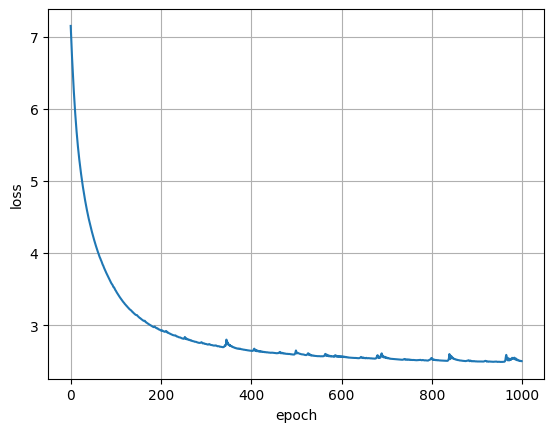

In [23]:
print(f'min loss: {min(losses)}')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);

max metric: -1.7744218111038208


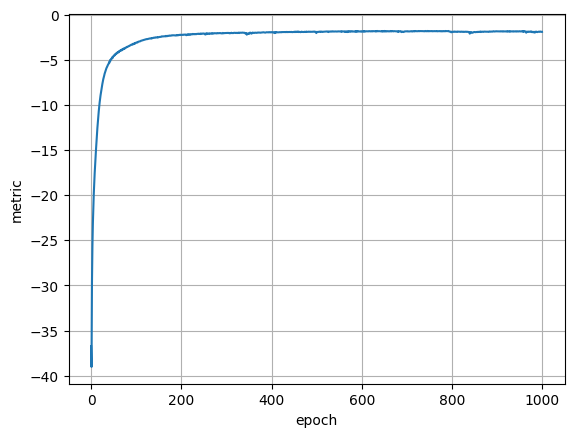

In [22]:
print(f'max metric: {max(metrics)}')

plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);

In [16]:
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

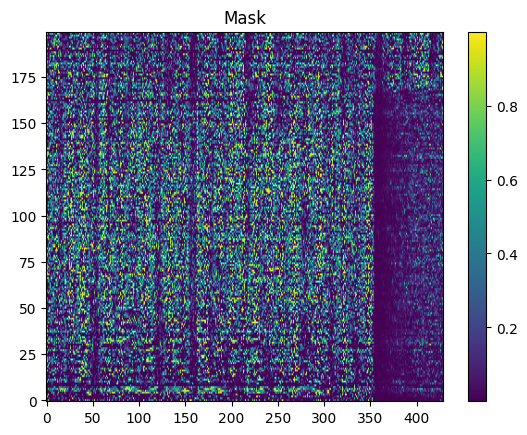

In [17]:
plot_mask(mask.detach()[0][0])

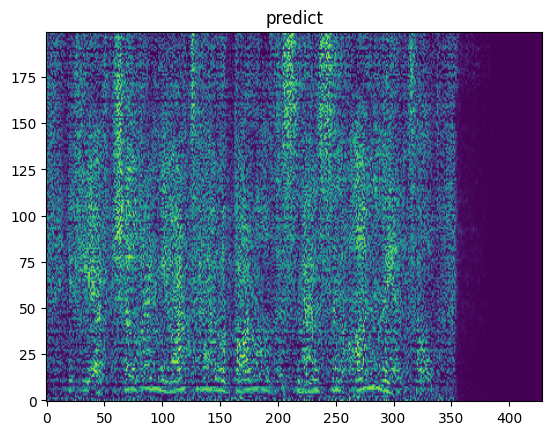

In [18]:
plt.title('predict')
plt.imshow(torch.log(mag_predict+1e-5).detach()[0][0], cmap="viridis", origin="lower", aspect="auto");

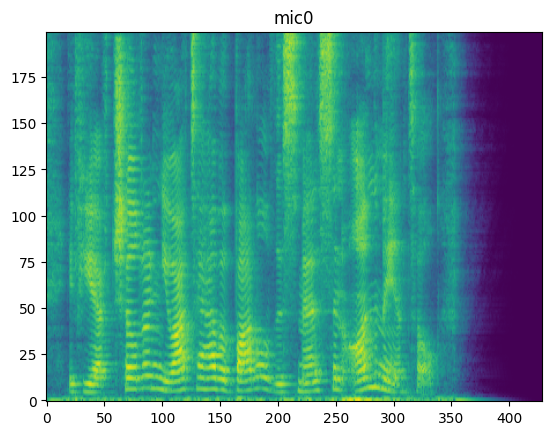

In [19]:
plt.title('mic0')
plt.imshow(torch.log(mag+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

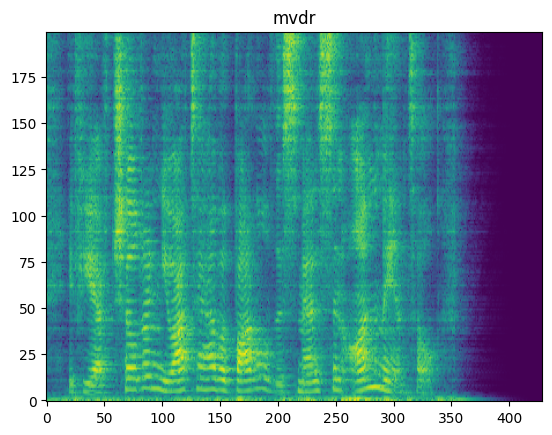

In [20]:
plt.title('mvdr')
plt.imshow(torch.log(mvdr(spec_sample, mask[0]).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");

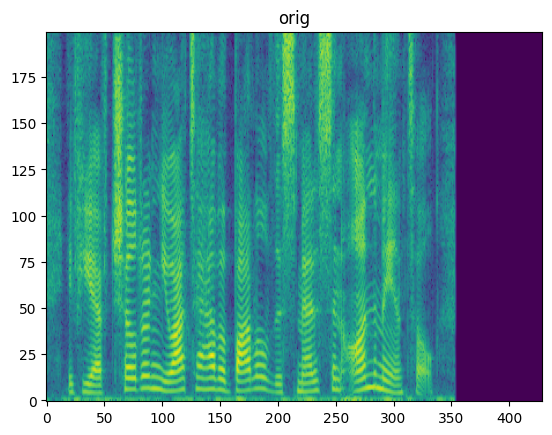

In [21]:
plt.title('orig')
plt.imshow(torch.log(stft.stft(train_target).abs()+1e-5).detach()[0], cmap="viridis", origin="lower", aspect="auto");